In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/home/federico/Università/Tesi_magistrale/my_programs/')

from contact_matrix_utils import *
from settings import *
from src.slice_pairwise import *
from src.interchromosomal_cosegregation import *
from src.slice_pairwise_inter import *
from numpy.random import Generator, MT19937
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import squareform

plt.style.use('default')

In [3]:
def chromosome_bin_lenght(segregation_table, chrom):
    return np.ceil(segregation_table[chrom]['stop_position'][-1]/resolution).astype(int)

def select_chromosomes_coordinates(chrA, chrB, chr_windows_sizes):
    if(chrA==0 or chrB ==0):
        print("0 is not accepted as chromosome index ")
        return

    chrA_idx, chrB_idx = chrA - 1, chrB - 1

    if(chrA_idx>chrB_idx):
        chrA_idx, chrB_idx = chrB_idx, chrA_idx

    start_row    = np.sum(chr_windows_sizes[:chrA_idx])
    stop_row     = start_row + chr_windows_sizes[chrA_idx]
    start_column = np.sum(chr_windows_sizes[:chrB_idx])
    stop_column  = start_column + chr_windows_sizes[chrB_idx]

    return start_row, stop_row, start_column, stop_column


# Data preparation and info #

In [4]:
#1NP
name_root_1NP_1Mb = "mesc_46C_1Mb_481x1"
path_1 =      r"/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/" + name_root_1NP_1Mb + "/"
file_name_1 = "segregation_" + name_root_1NP_1Mb +  ".pkl"
with open(path_1 + file_name_1, 'rb') as f_1:
    segregation_table_1NP = pickle.load(f_1)

gw_coseg_matrix_1NP, gw_npmi_1NP = compute_coseg_npmi_genomewide(segregation_table_1NP, 1, 19)

gw_coseg_matrix_1NP[gw_coseg_matrix_1NP == 0] = np.nan
gw_npmi_1NP[gw_npmi_1NP == 0] = np.nan

# For each chromosome, compute F_arr and store it in F_arr_genomewide
chr_list = list(dict({"chr1": 1, "chr2": 2, "chr3": 3, "chr4": 4,
                             "chr5": 5, "chr6": 6, "chr7": 7, "chr8": 8,
                             "chr9": 9, "chr10": 10, "chr11": 11, "chr12": 12,
                             "chr13": 13, "chr14": 14, "chr15": 15, "chr16": 16,
                             "chr17": 17, "chr18": 18, "chr19": 19}).keys())

F_arr_genomewide_1NP_1Mb = np.array([])

for chr in chr_list:
    segregation_table = segregation_table_1NP[chr]["segregation_table"]
    F_arr = compute_tube_segregation_frequency(segregation_table)
    F_arr_genomewide_1NP_1Mb = np.concatenate((F_arr_genomewide_1NP_1Mb, F_arr))
    del F_arr

del segregation_table


start_chr, stop_chr = 1, 19
stop_chr += 1
chromosomes = []
n_chromosomes = stop_chr - start_chr

l = []
size = 0

for i in range(start_chr, stop_chr):
    chrA = 'chr' + str(i)
    chromosomes += [chrA]
    s = segregation_table_1NP[chrA]['segregation_table'].shape[0]
    size += s
    l.append(s) 

chr_windows_sizes = np.array(l)

for i in range(gw_coseg_matrix_1NP.shape[0]):
    for j in range(gw_coseg_matrix_1NP.shape[1]):
        gw_coseg_matrix_1NP[j,i] = gw_coseg_matrix_1NP[i,j]
        gw_npmi_1NP[j,i] = gw_npmi_1NP[i, j]


  0%|          | 0/19 [00:00<?, ?it/s]/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/src/utilities.py:40: RuntimeWarning: divide by zero encountered in log
  npmi_mat = - np.log(F_ij / (F_i * F_j)) / np.log(F_ij)
/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/src/utilities.py:56: RuntimeWarning: divide by zero encountered in log
  npmi_mat = - np.log(F_ij / (F_i * F_j)) / np.log(F_ij)


In [5]:
F_i = np.tile(F_arr_genomewide_1NP_1Mb, (len(F_arr_genomewide_1NP_1Mb), 1))
F_j = np.transpose(F_i)
R_ij_gw_1NP_1Mb = gw_coseg_matrix_1NP / (F_i + F_j - gw_coseg_matrix_1NP)
del F_i, F_j

In [6]:
print("Dimensioni del dataset: " , gw_coseg_matrix_1NP.shape)
print("Numero di nan nella coseg"  , np.argwhere(gw_coseg_matrix_1NP != gw_coseg_matrix_1NP).shape)
print("Numero di nan nella nld  "    , np.argwhere(gw_npmi_1NP != gw_npmi_1NP).shape)

print("Numero di zeri nella coseg "  , np.argwhere(gw_coseg_matrix_1NP == 0).shape)
print("Numero di zeri nella nld "  ,   np.argwhere(gw_npmi_1NP == 0).shape)

Dimensioni del dataset:  (2473, 2473)
Numero di nan nella coseg (1091407, 2)
Numero di nan nella nld   (1091407, 2)
Numero di zeri nella coseg  (0, 2)
Numero di zeri nella nld  (0, 2)


# $F_i \cdot F_j$ coseg corr #

In [7]:
F_i_outer_Fj_1NP_1Mb = np.outer(F_arr_genomewide_1NP_1Mb, F_arr_genomewide_1NP_1Mb)
F_i_outer_Fj_1NP_1Mb[F_i_outer_Fj_1NP_1Mb == 0] = np.nan
np.fill_diagonal(F_i_outer_Fj_1NP_1Mb, np.nan)

(0.6961890873620559, 0.0)
SpearmanrResult(correlation=0.7256243643752688, pvalue=0.0)


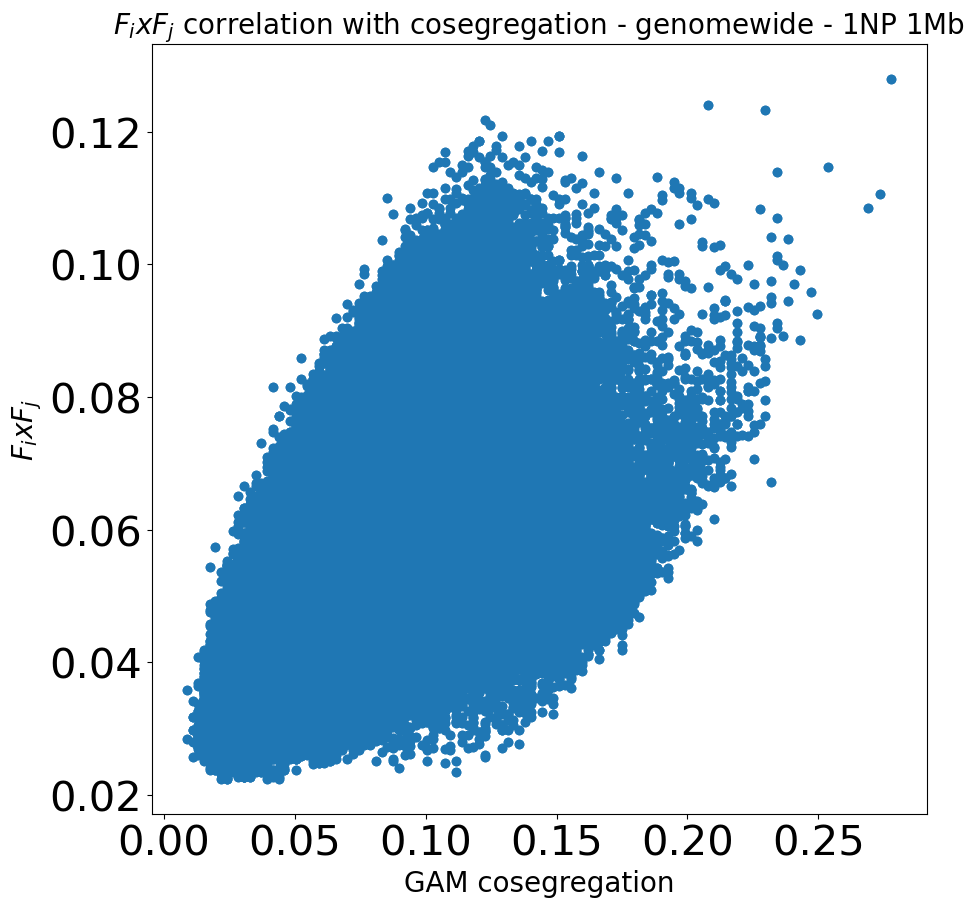

In [8]:
fig, ax = plt.subplots(1, figsize = (10,10))

mat = gw_coseg_matrix_1NP
mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb)

ax.scatter(mat, mat_1);
ax.set_xlabel("GAM cosegregation", fontsize = 20);
ax.set_ylabel("$F_i x F_j$", fontsize = 20);

ax.set_title("$F_i x F_j$ correlation with cosegregation - genomewide - 1NP 1Mb", fontsize = 20)
ax.tick_params(axis='x', which='major', labelsize=30)
ax.tick_params(axis='y', which='major', labelsize=30)


f_mat = mat.flatten()
f_mat_1 = mat_1.flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print(pearsonr(f_mat, f_mat_1))
print(spearmanr(f_mat, f_mat_1))

del mat, mat_1, fig, ax, f_mat, f_mat_1

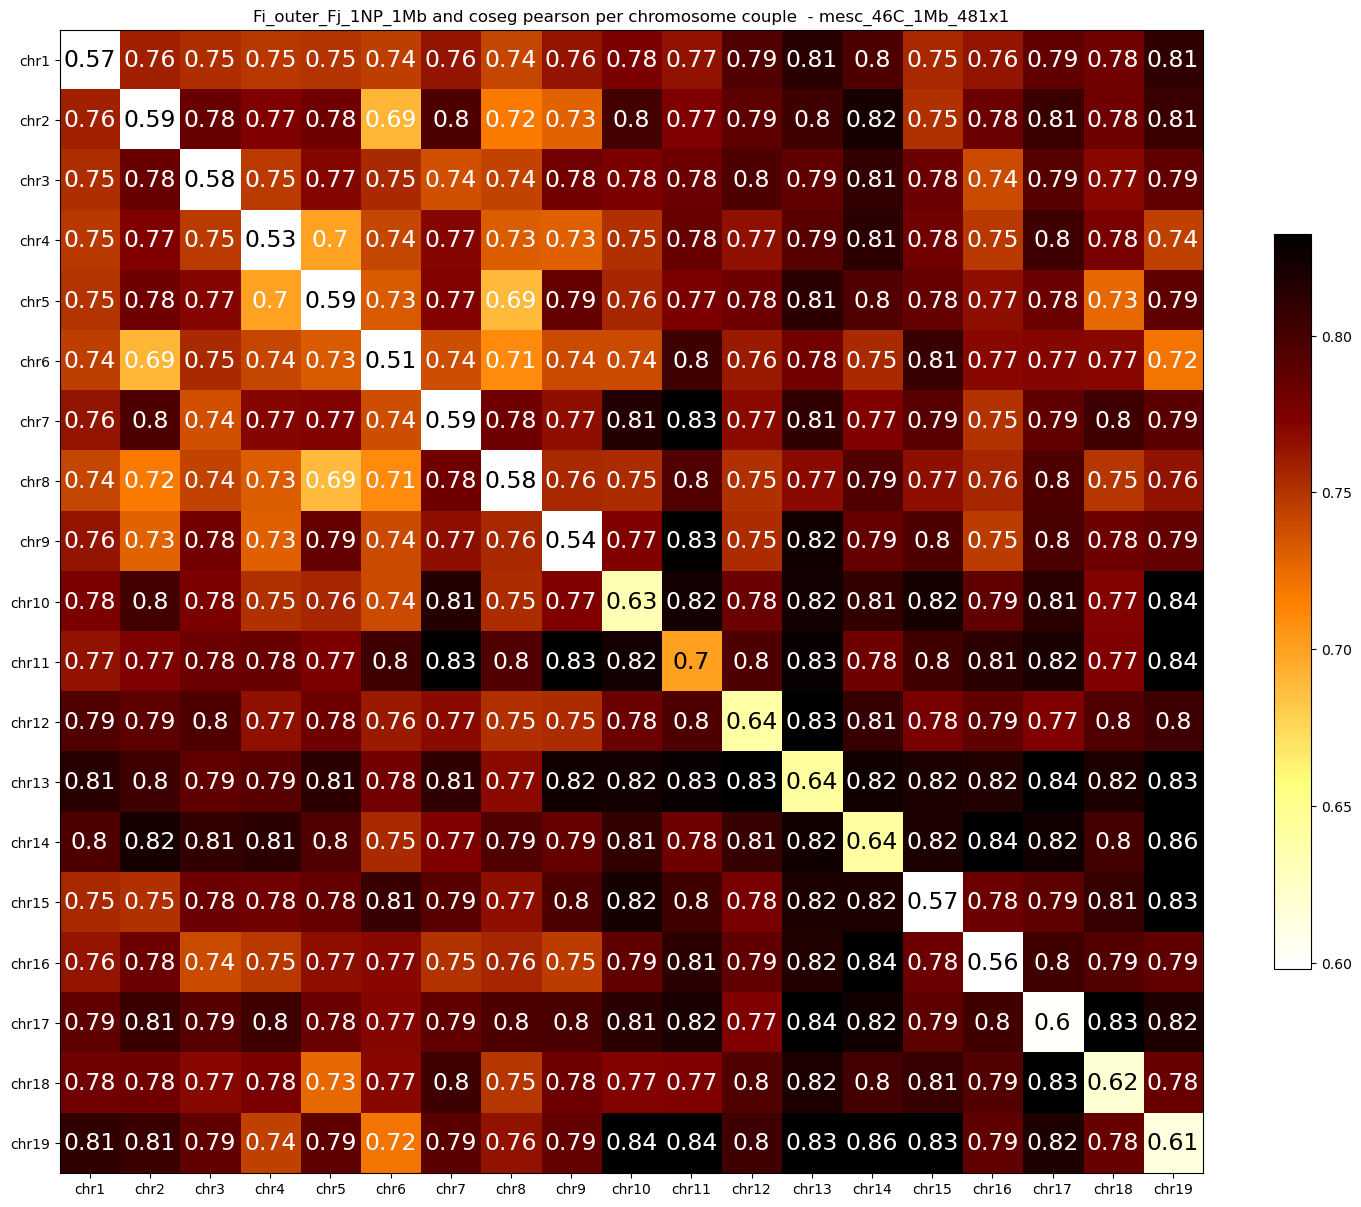

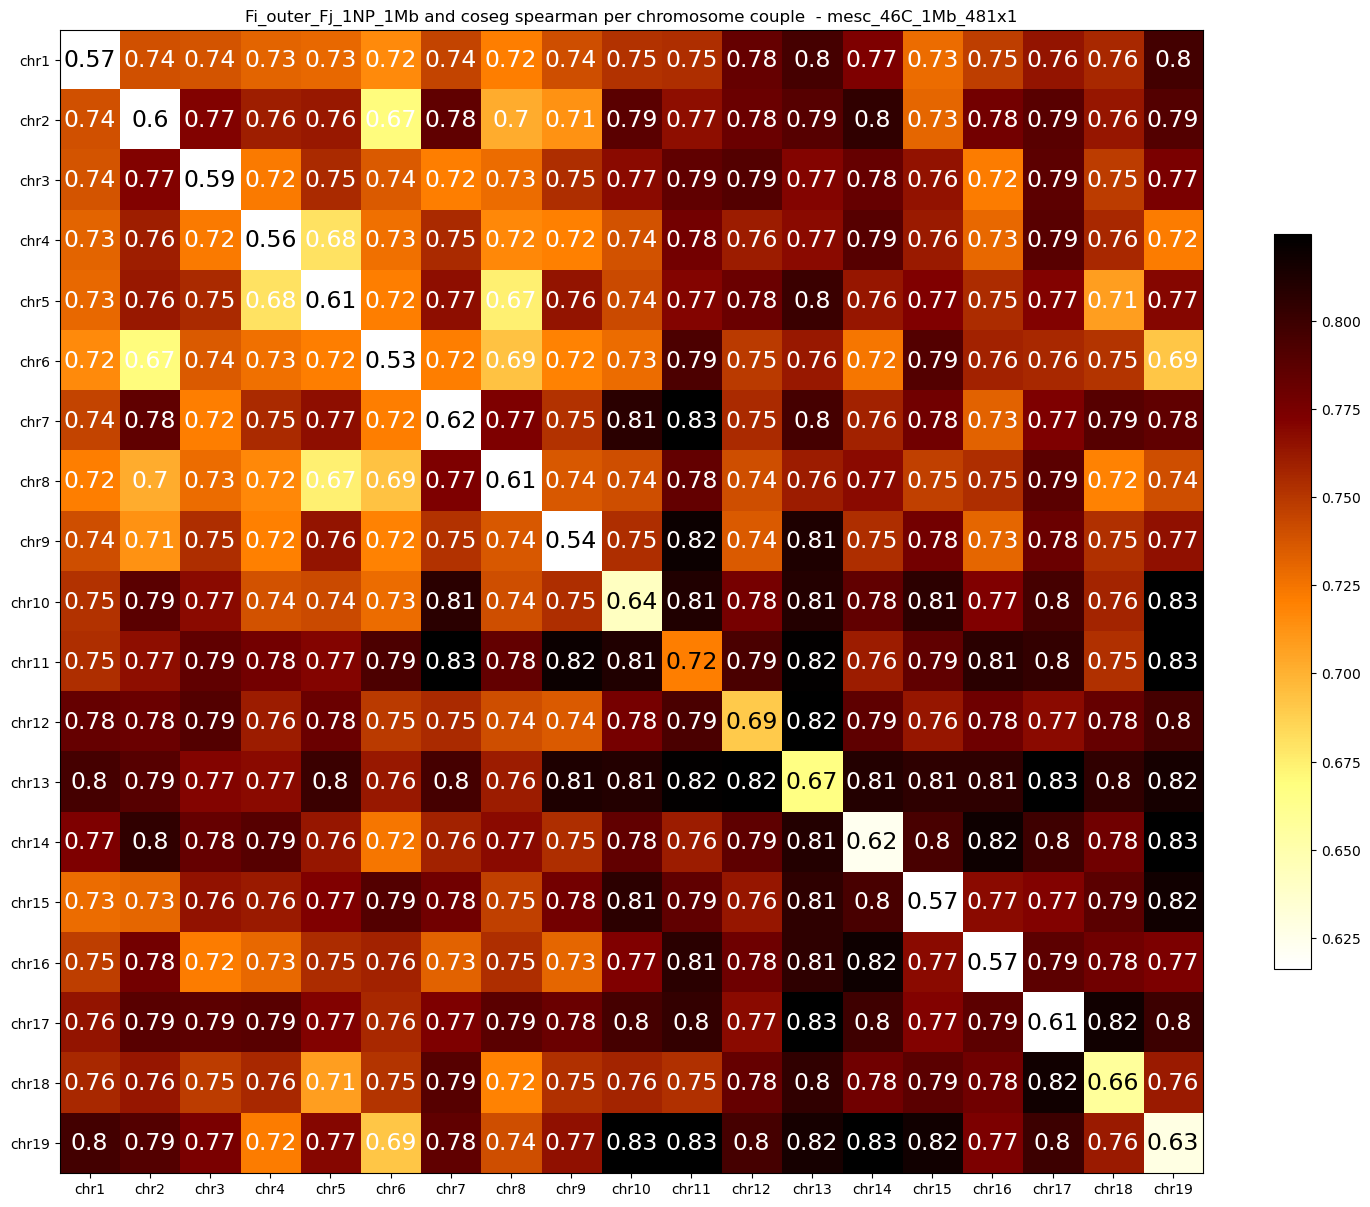

In [9]:
coseg_FixFj_pearson_1NP = np.zeros((19,19))
coseg_FixFj_spearman_1NP = np.zeros((19,19))

for i in range(n_chromosomes):
    for j in range(n_chromosomes):
        start_row    = np.sum(chr_windows_sizes[:i])
        stop_row     = start_row + chr_windows_sizes[i]
        start_column = np.sum(chr_windows_sizes[:j])
        stop_column  = start_column + chr_windows_sizes[j]
        chrA = chromosomes[i]
        chrB = chromosomes[j]


        f_mat = gw_coseg_matrix_1NP[start_row:stop_row, start_column:stop_column].flatten()
        f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[start_row:stop_row, start_column:stop_column]).flatten()
        bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

        f_mat = np.compress(bad, f_mat)  
        f_mat_1 = np.compress(bad, f_mat_1)  

        coseg_FixFj_pearson_1NP[i, j] = pearsonr(f_mat, f_mat_1)[0]
        coseg_FixFj_spearman_1NP[i, j] = spearmanr(f_mat, f_mat_1)[0]
            

fig, ax, _, _ = plot_heatmap(coseg_FixFj_pearson_1NP, x_figsize= 15, y_figsize= 15)
fig1, ax1, _, _ = plot_heatmap(coseg_FixFj_spearman_1NP, x_figsize= 15, y_figsize= 15)

for i in range(19):
    for j in range(19):
        if(i!=j):
            text = ax.text(j, i, np.around(coseg_FixFj_pearson_1NP[i, j], decimals=2),
                        ha="center", va="center", color="white", fontsize = 17)
            text = ax1.text(j, i, np.around(coseg_FixFj_spearman_1NP[i, j], decimals=2),
                        ha="center", va="center", color="white", fontsize = 17)
        if(i==j):
            text = ax.text(j, i, np.around(coseg_FixFj_pearson_1NP[i, j], decimals=2),
                        ha="center", va="center", color="black", fontsize = 17)
            text = ax1.text(j, i, np.around(coseg_FixFj_spearman_1NP[i, j], decimals=2),
                        ha="center", va="center", color="black", fontsize = 17)


ax.set_title("Fi_outer_Fj_1NP_1Mb and coseg pearson per chromosome couple " + " - " + name_root_1NP_1Mb)
fig.tight_layout()
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);

ax1.set_title("Fi_outer_Fj_1NP_1Mb and coseg spearman per chromosome couple " + " - " + name_root_1NP_1Mb)
fig1.tight_layout()
ax1.set_xticks(np.arange(0,19, 1))
ax1.set_yticks(np.arange(0,19, 1))
ax1.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax1.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);


del fig, ax, fig1, ax1

In [10]:
for i in range(19):
    for j in range(19):
        if(j<i):
            coseg_FixFj_pearson_1NP[i,j] = np.nan
            coseg_FixFj_spearman_1NP[i,j] = np.nan
    

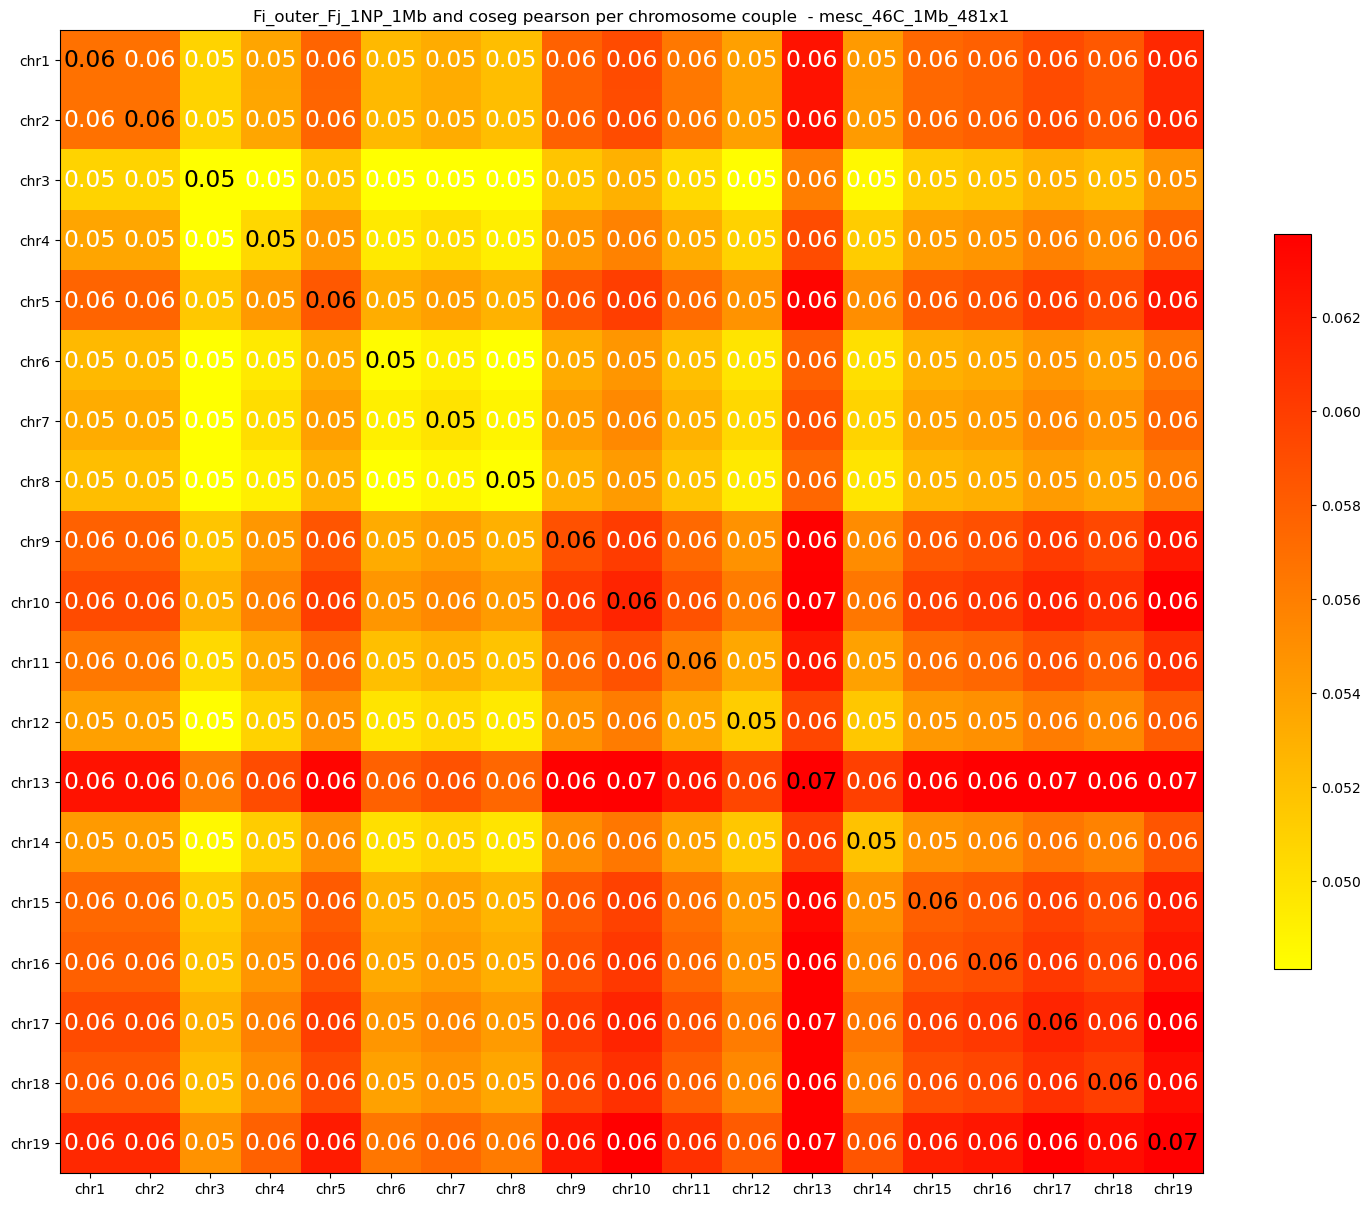

In [11]:
FixFj_mean_1NP = np.zeros((19,19))

for i in range(n_chromosomes):
    for j in range(n_chromosomes):
        start_row    = np.sum(chr_windows_sizes[:i])
        stop_row     = start_row + chr_windows_sizes[i]
        start_column = np.sum(chr_windows_sizes[:j])
        stop_column  = start_column + chr_windows_sizes[j]
        chrA = chromosomes[i]
        chrB = chromosomes[j]

        FixFj_mean_1NP[i, j] = np.nanmean(F_i_outer_Fj_1NP_1Mb[start_row:stop_row, start_column:stop_column])
            

fig, ax, _, _ = plot_heatmap(FixFj_mean_1NP, x_figsize= 15, y_figsize= 15, colormap= "autumn_r")

for i in range(19):
    for j in range(19):
        if(i!=j):
            text = ax.text(j, i, np.around(FixFj_mean_1NP[i, j], decimals=2),
                        ha="center", va="center", color="white", fontsize = 17)

        if(i==j):
            text = ax.text(j, i, np.around(FixFj_mean_1NP[i, j], decimals=2),
                        ha="center", va="center", color="black", fontsize = 17)



ax.set_title("Fi_outer_Fj_1NP_1Mb and coseg pearson per chromosome couple " + " - " + name_root_1NP_1Mb)
fig.tight_layout()
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);



del fig, ax

(<Figure size 700x700 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7fa21b7add90>)

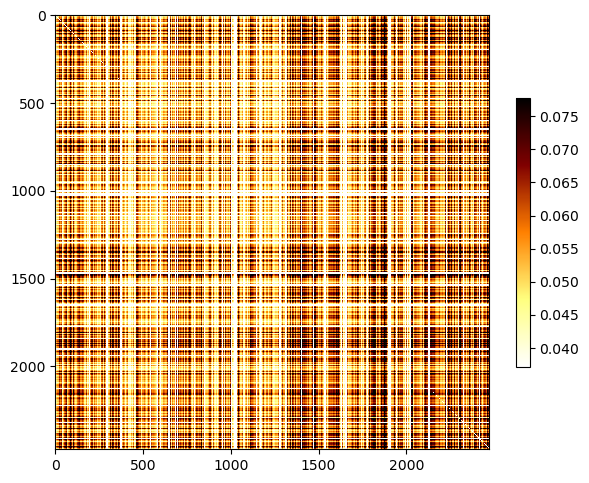

In [12]:
plot_heatmap(F_i_outer_Fj_1NP_1Mb)

# Exploration # 

In [13]:
def running_mean(x, N):
    cumsum = np.nancumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [14]:
running_mean(F_arr_genomewide_1NP_1Mb, 10)

array([0.1571116 , 0.18030635, 0.20371991, ..., 0.23019694, 0.2356674 ,
       0.21466083])

average:  0.23529319906226276 std:  0.03253476597424682


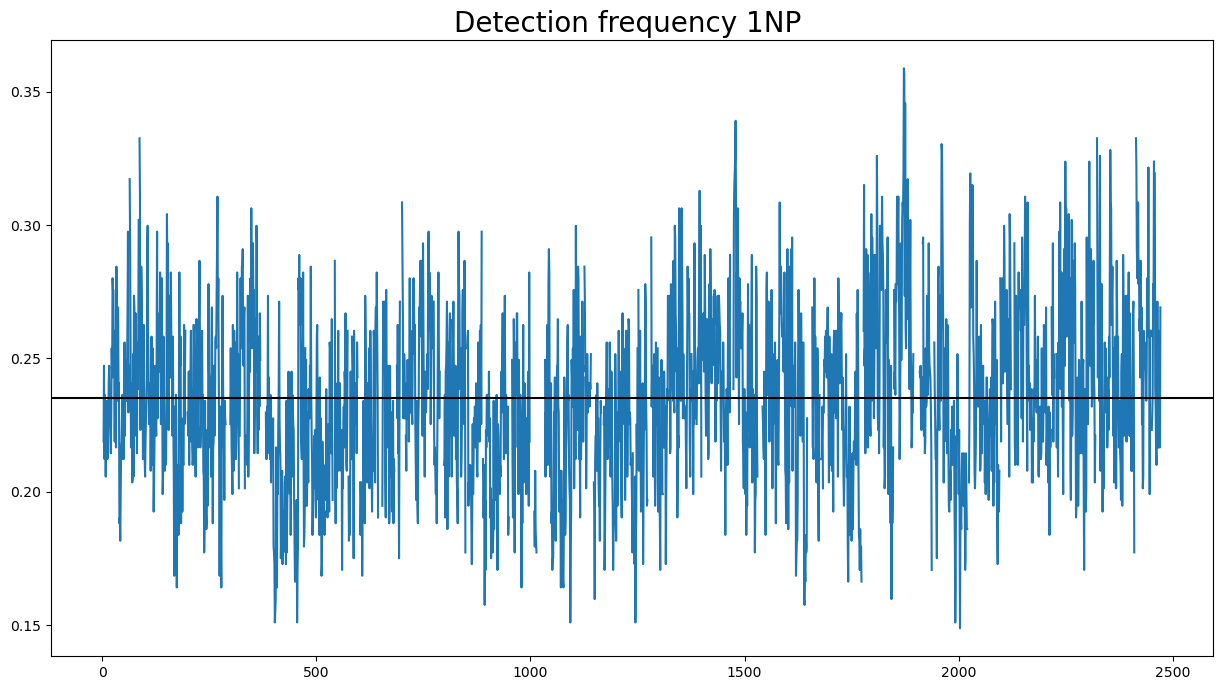

In [15]:
fig, ax = plt.subplots(1, figsize = (15, 8))

ax.plot(F_arr_genomewide_1NP_1Mb)
ax.axhline(np.nanmean(F_arr_genomewide_1NP_1Mb), color = "black");
ax.set_title("Detection frequency 1NP ", fontsize = 20)

print("average: ", np.nanmean(F_arr_genomewide_1NP_1Mb), "std: ", np.nanstd(F_arr_genomewide_1NP_1Mb))

del fig, ax

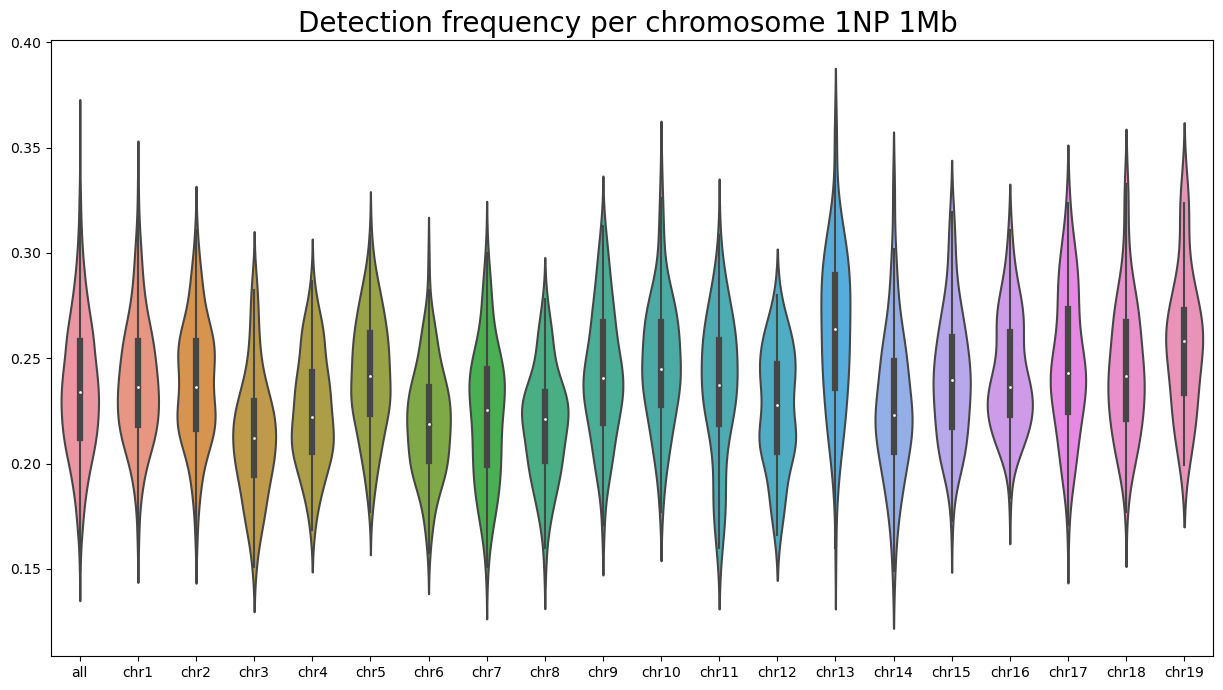

In [16]:
import seaborn as sns

fig, ax = plt.subplots(1, figsize = (15, 8))
l = []
l.append(F_arr_genomewide_1NP_1Mb)
for i in range(19):
    start, stop, _, _ = select_chromosomes_coordinates(i+1, i+1, chr_windows_sizes)
    # mean = np.nanmean(F_arr_genomewide_1NP_1Mb[start:stop])
    # std = np.nanstd(F_arr_genomewide_1NP_1Mb[start:stop])
    l.append(F_arr_genomewide_1NP_1Mb[start:stop])


ax = sns.violinplot(data = l )
ax.set_xticks(np.arange(0,20, 1))
ax.set_xticklabels(['all', 'chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);

ax.set_title("Detection frequency per chromosome 1NP 1Mb ", fontsize = 20)

del fig, ax

# less NP #

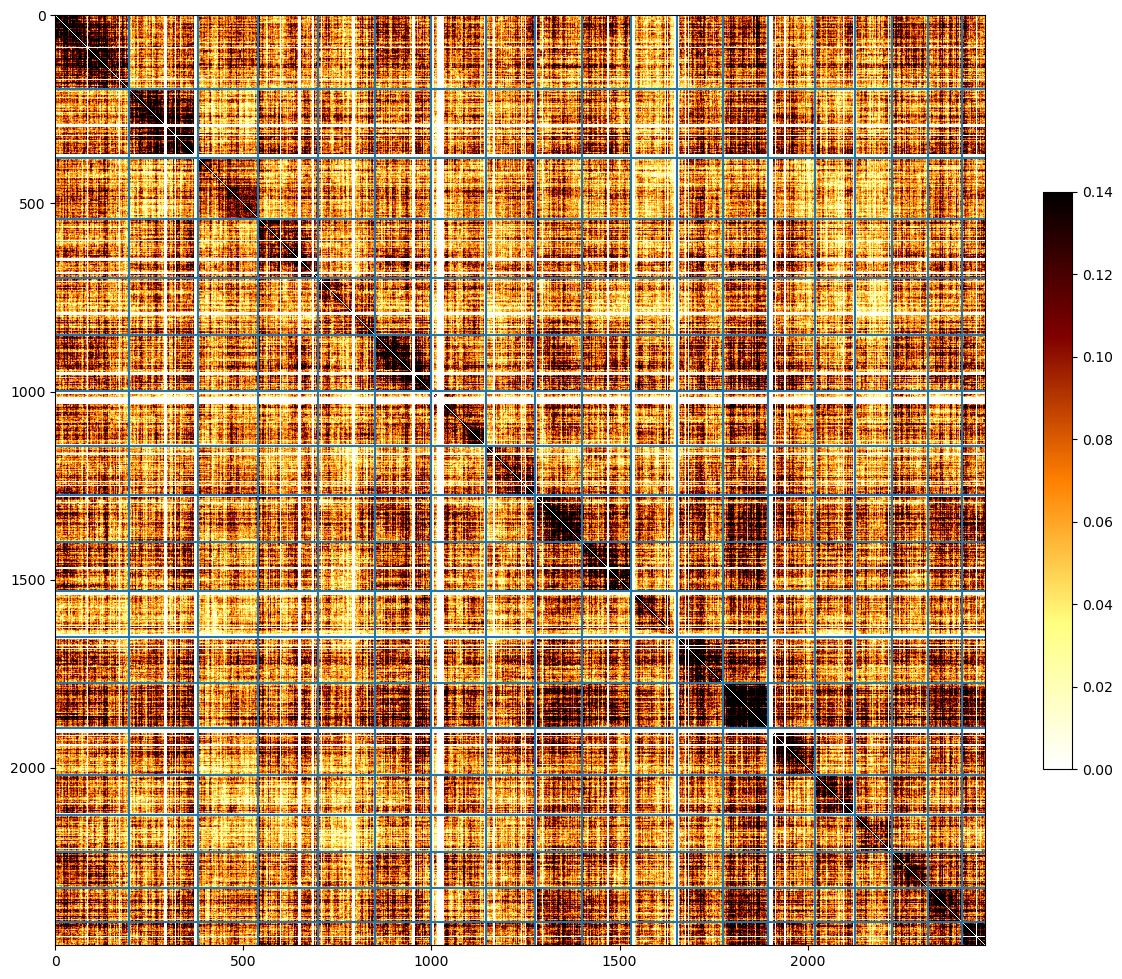

In [17]:
single_np_1NP_seg_table = segregation_table_1NP.copy()
w = 100
for chrom in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13','chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']: 
    single_np_1NP_seg_table[chrom]['segregation_table'] = segregation_table_1NP[chrom]['segregation_table'][:,:w]
np_1_coseg  = compute_coseg_genomewide(single_np_1NP_seg_table, 1, 19 )
for i in range(np_1_coseg.shape[0]):
    for j in range(np_1_coseg.shape[1]):
        np_1_coseg[j,i] = np_1_coseg[i,j]
np_1_coseg[np_1_coseg != np_1_coseg] = 0

fig, ax, _, _ = plot_heatmap(np_1_coseg,  x_figsize=15, y_figsize=15)
for i in np.cumsum(chr_windows_sizes)[:-1]:
    ax.axhline(i);
    ax.axvline(i);

del fig, ax

In [18]:
single_np_1NP_seg_freq = np.array([])
for chrom in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13','chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']: 
    single_np_1NP_seg_freq = np.concatenate((single_np_1NP_seg_freq, compute_tube_segregation_frequency(single_np_1NP_seg_table[chrom]['segregation_table'])))
F_ixF_j_single_np_1NP = np.outer(single_np_1NP_seg_freq, single_np_1NP_seg_freq)
np.fill_diagonal(F_ixF_j_single_np_1NP, np.nan)
F_ixF_j_single_np_1NP[F_ixF_j_single_np_1NP != F_ixF_j_single_np_1NP] = 0 

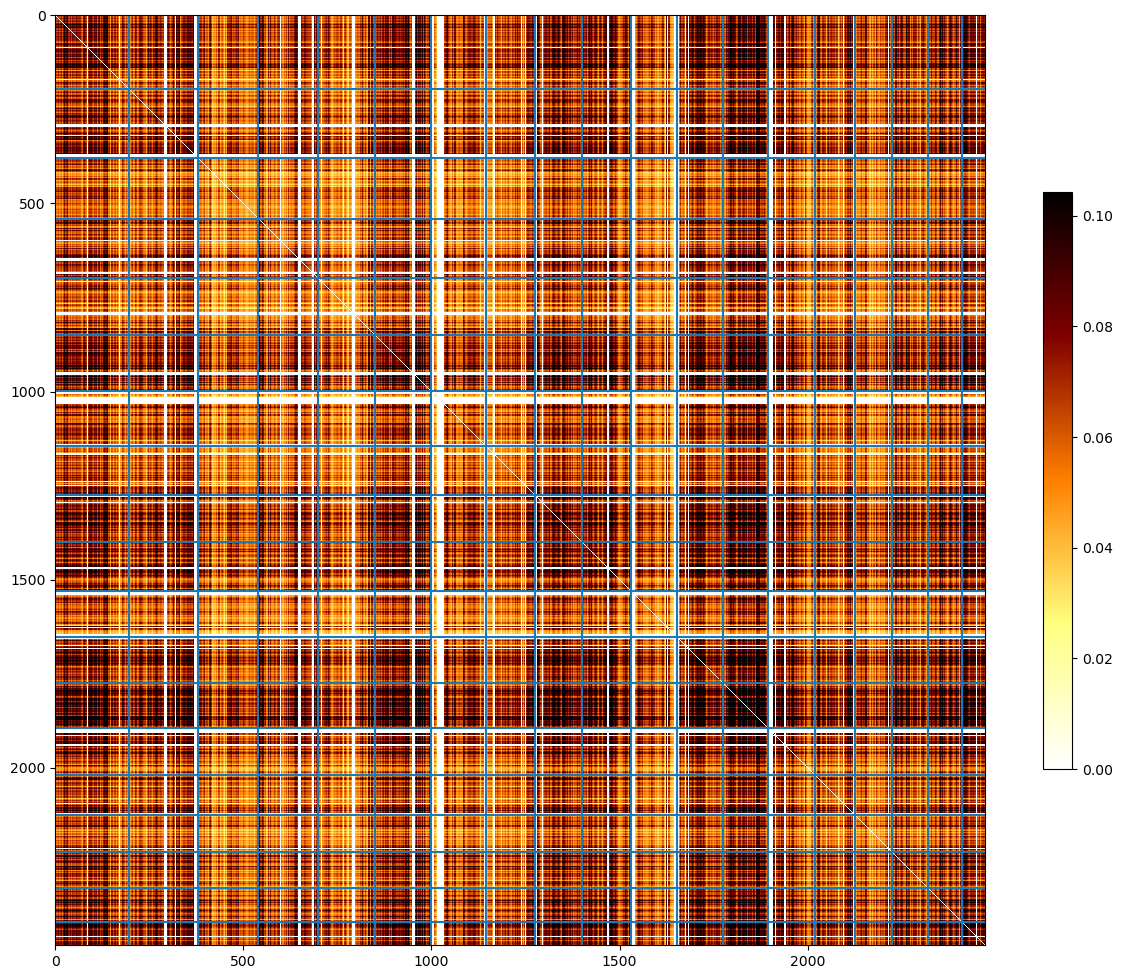

In [19]:
fig, ax, _, _ = plot_heatmap(F_ixF_j_single_np_1NP, x_figsize=15, y_figsize=15)
for i in np.cumsum(chr_windows_sizes)[:-1]:
    ax.axhline(i);
    ax.axvline(i);

del fig, ax

(0.8630529541806785, 0.0)
SpearmanrResult(correlation=0.8174613706006886, pvalue=0.0)


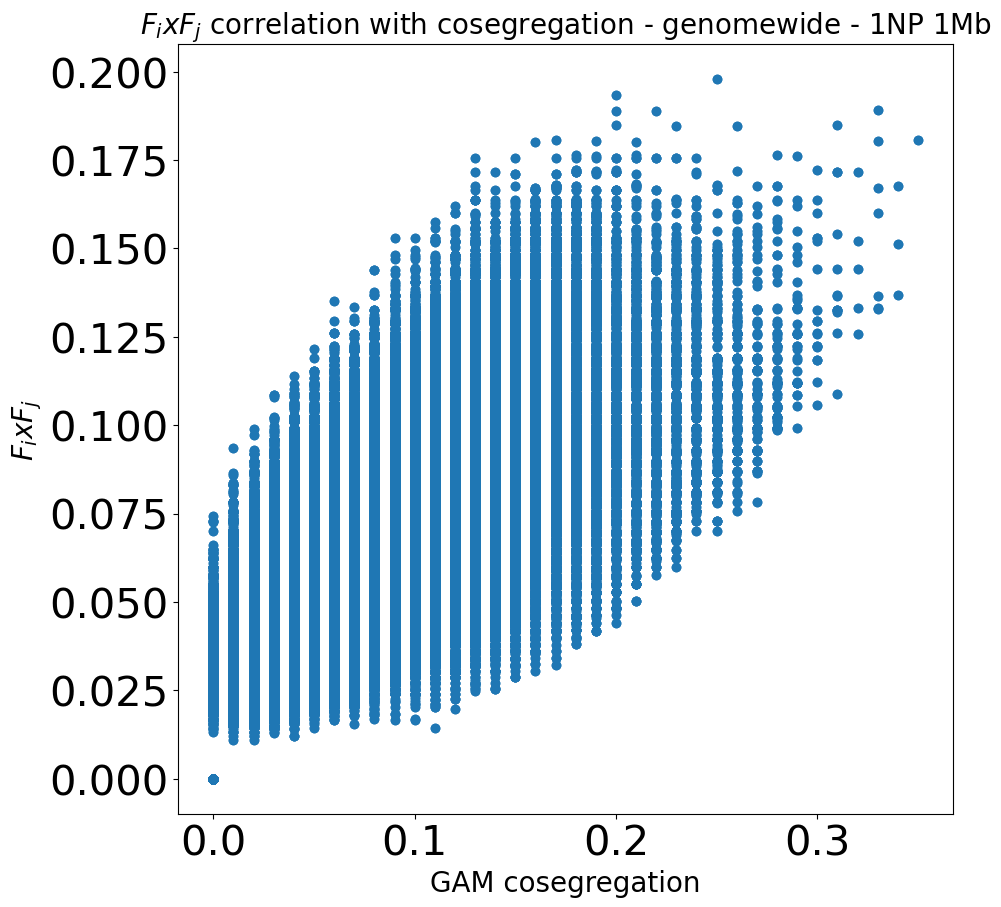

In [20]:
fig, ax = plt.subplots(1, figsize = (10,10))

mat = np_1_coseg
mat_1 = np.copy(F_ixF_j_single_np_1NP)

ax.scatter(mat, mat_1);
ax.set_xlabel("GAM cosegregation", fontsize = 20);
ax.set_ylabel("$F_i x F_j$", fontsize = 20);

ax.set_title("$F_i x F_j$ correlation with cosegregation - genomewide - 1NP 1Mb", fontsize = 20)
ax.tick_params(axis='x', which='major', labelsize=30)
ax.tick_params(axis='y', which='major', labelsize=30)


f_mat = mat.flatten()
f_mat_1 = mat_1.flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print(pearsonr(f_mat, f_mat_1))
print(spearmanr(f_mat, f_mat_1))

del mat, mat_1, fig, ax, f_mat, f_mat_1

In [21]:
segregation_table_1NP['chr1']['segregation_table'].shape[1]

457

(<Figure size 700x700 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7fa21b3edd90>)

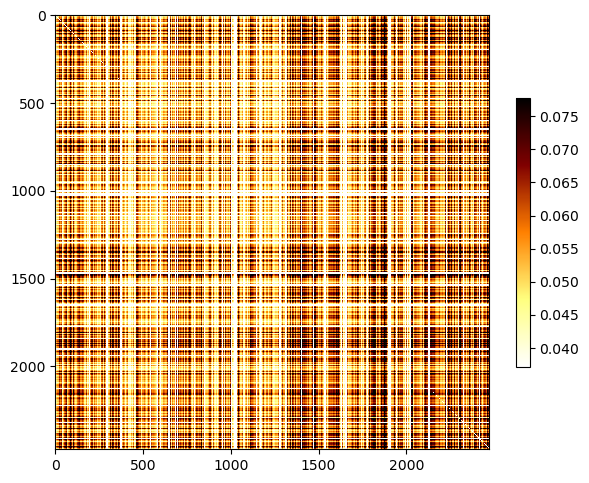

In [22]:
plot_heatmap(F_i_outer_Fj_1NP_1Mb)

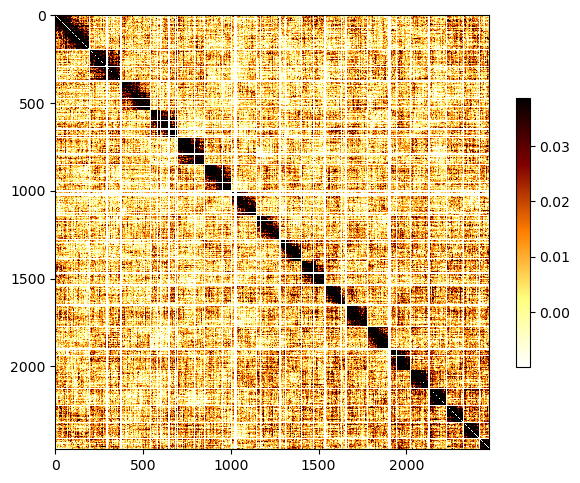

In [23]:
plot_heatmap(gw_coseg_matrix_1NP - F_i_outer_Fj_1NP_1Mb);

In [24]:
gw_coseg_matrix_1NP[150, 190], F_i_outer_Fj_1NP_1Mb[150, 190]

(0.08533916849015317, 0.05010318459748431)

In [25]:
np.nanmean(F_i_outer_Fj_1NP_1Mb), np.nanmean(gw_coseg_matrix_1NP)

(0.055362417186266805, 0.06472930930362211)

# $F_i \cdot F_j$ npmi corr #

(0.05512611292579587, 0.0)
SpearmanrResult(correlation=0.06411051688912281, pvalue=0.0)


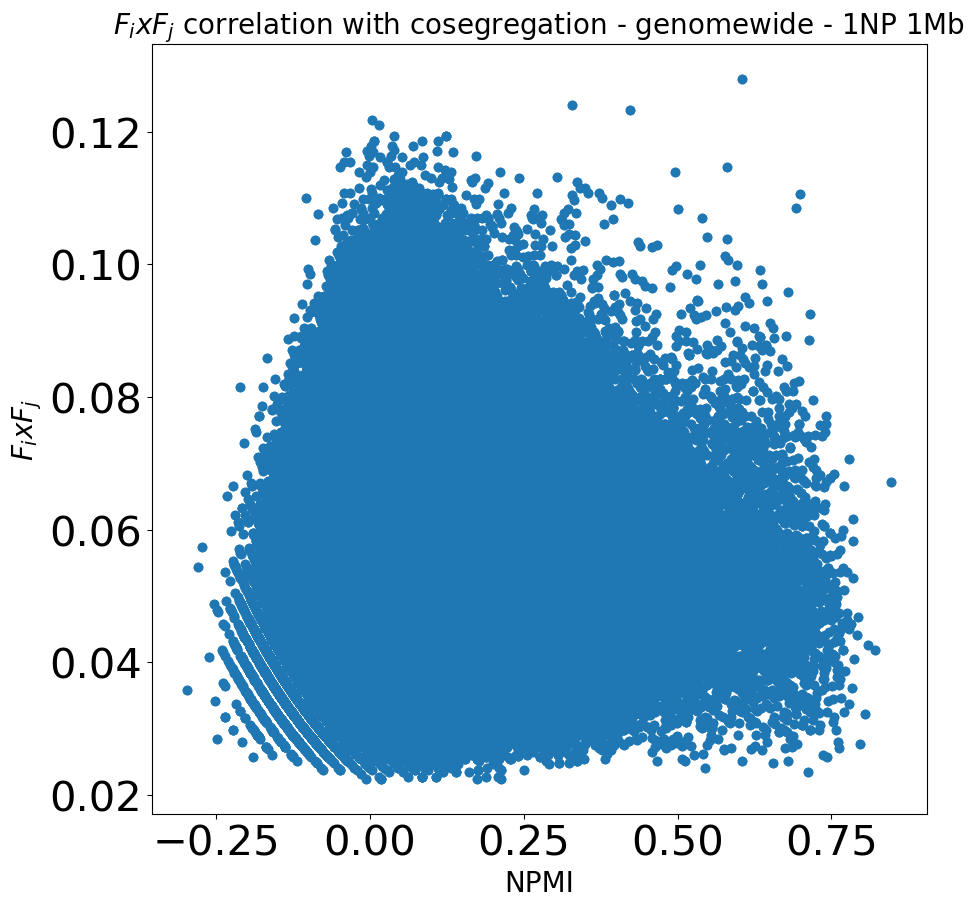

In [26]:
fig, ax = plt.subplots(1, figsize = (10,10))

mat = gw_npmi_1NP
mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb)

ax.scatter(mat, mat_1);
ax.set_xlabel("NPMI", fontsize = 20);
ax.set_ylabel("$F_i x F_j$", fontsize = 20);

ax.set_title("$F_i x F_j$ correlation with cosegregation - genomewide - 1NP 1Mb", fontsize = 20)
ax.tick_params(axis='x', which='major', labelsize=30)
ax.tick_params(axis='y', which='major', labelsize=30)


f_mat = mat.flatten()
f_mat_1 = mat_1.flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print(pearsonr(f_mat, f_mat_1))
print(spearmanr(f_mat, f_mat_1))

del mat, mat_1, fig, ax, f_mat, f_mat_1

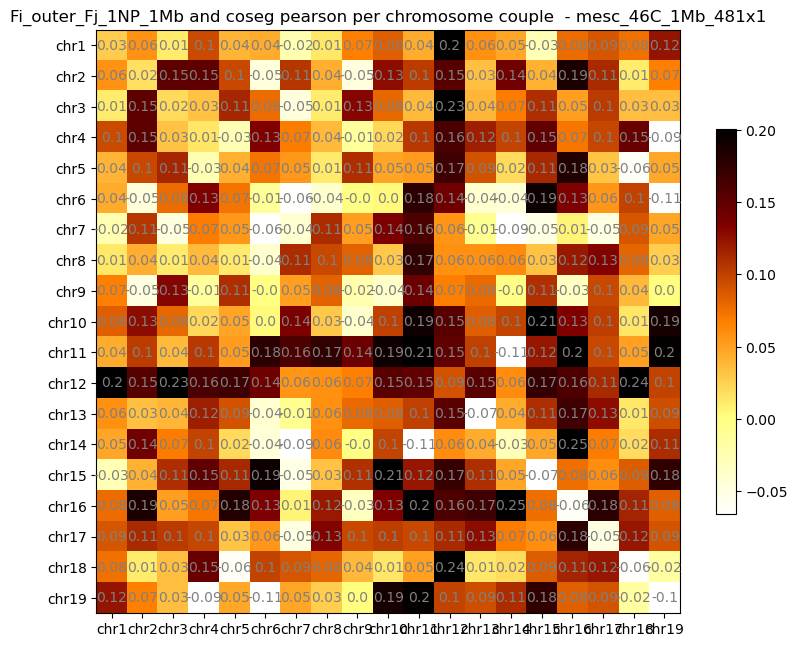

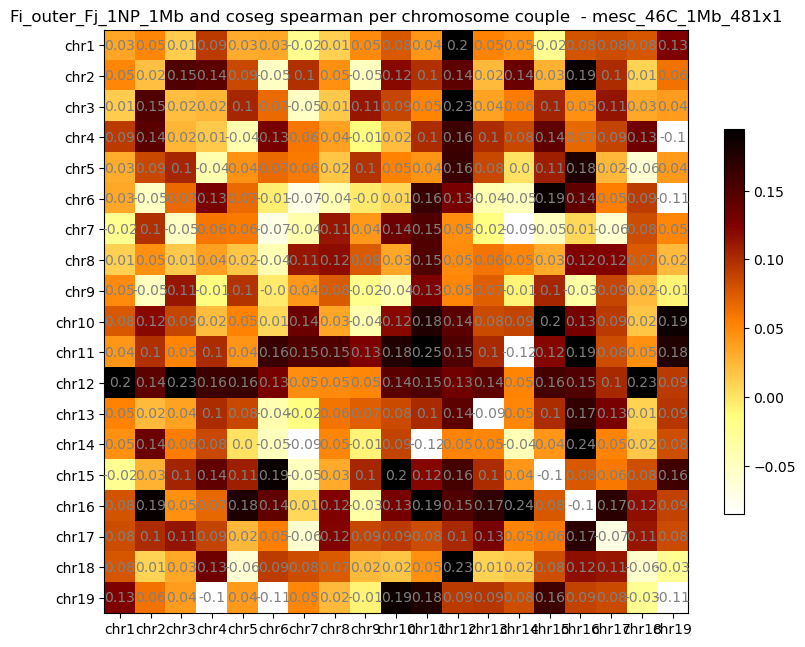

In [27]:
npmi_FixFj_pearson = np.zeros((19,19))
npmi_FixFj_spearman = np.zeros((19,19))

for i in range(n_chromosomes):
    for j in range(n_chromosomes):
        start_row    = np.sum(chr_windows_sizes[:i])
        stop_row     = start_row + chr_windows_sizes[i]
        start_column = np.sum(chr_windows_sizes[:j])
        stop_column  = start_column + chr_windows_sizes[j]
        chrA = chromosomes[i]
        chrB = chromosomes[j]


        f_mat = gw_npmi_1NP[start_row:stop_row, start_column:stop_column].flatten()
        f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[start_row:stop_row, start_column:stop_column]).flatten()
        bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

        f_mat = np.compress(bad, f_mat)  
        f_mat_1 = np.compress(bad, f_mat_1)  

        npmi_FixFj_pearson[i, j] = pearsonr(f_mat, f_mat_1)[0]
        npmi_FixFj_spearman[i, j] = spearmanr(f_mat, f_mat_1)[0]
            

fig, ax, _, _ = plot_heatmap(npmi_FixFj_pearson, x_figsize= 8, y_figsize= 8)
fig1, ax1, _, _ = plot_heatmap(npmi_FixFj_spearman, x_figsize= 8, y_figsize= 8)

for i in range(19):
    for j in range(19):
        text = ax.text(j, i, np.around(npmi_FixFj_pearson[i, j], decimals=2),
                       ha="center", va="center", color="grey")
        text = ax1.text(j, i, np.around(npmi_FixFj_spearman[i, j], decimals=2),
                       ha="center", va="center", color="grey")


ax.set_title("Fi_outer_Fj_1NP_1Mb and coseg pearson per chromosome couple " + " - " + name_root_1NP_1Mb)
fig.tight_layout()
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);

ax1.set_title("Fi_outer_Fj_1NP_1Mb and coseg spearman per chromosome couple " + " - " + name_root_1NP_1Mb)
fig1.tight_layout()
ax1.set_xticks(np.arange(0,19, 1))
ax1.set_yticks(np.arange(0,19, 1))
ax1.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax1.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);


del fig, ax, fig1, ax1

# $F_i \cdot F_j$ R_ij corr #

(0.40566157902821387, 0.0)
SpearmanrResult(correlation=0.4830500239596117, pvalue=0.0)


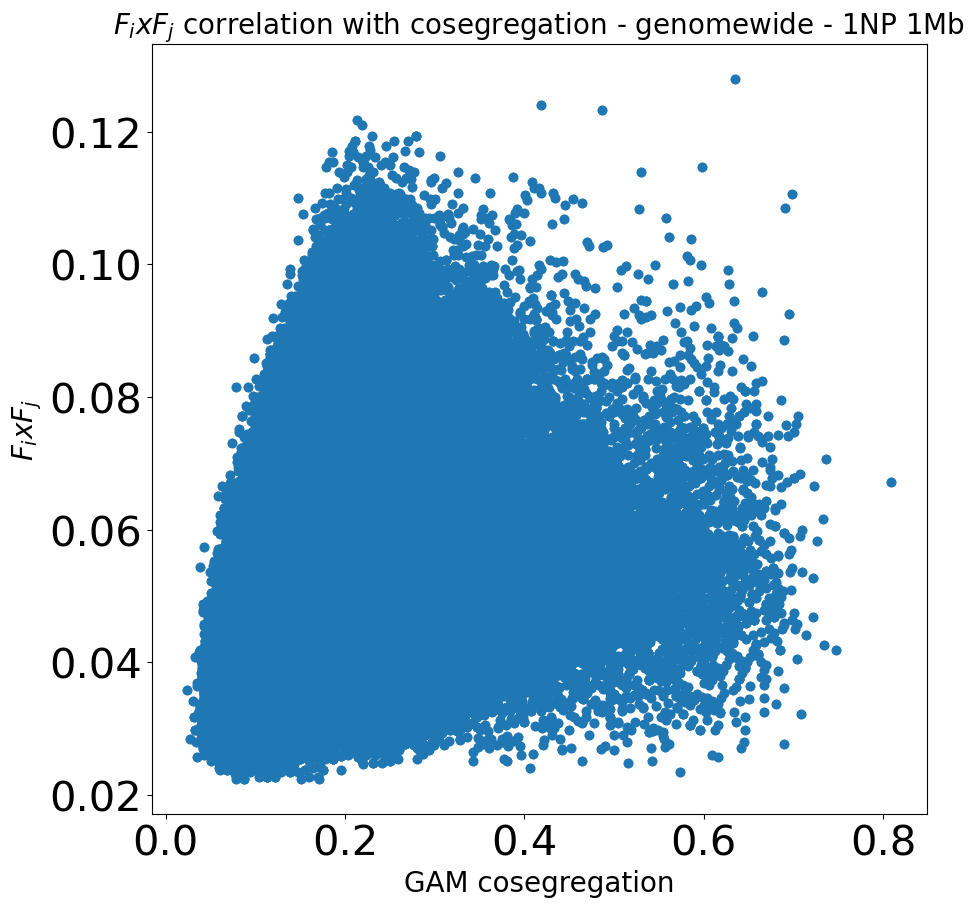

In [28]:
fig, ax = plt.subplots(1, figsize = (10,10))

mat = R_ij_gw_1NP_1Mb
mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb)

ax.scatter(mat, mat_1);
ax.set_xlabel("GAM cosegregation", fontsize = 20);
ax.set_ylabel("$F_i x F_j$", fontsize = 20);

ax.set_title("$F_i x F_j$ correlation with cosegregation - genomewide - 1NP 1Mb", fontsize = 20)
ax.tick_params(axis='x', which='major', labelsize=30)
ax.tick_params(axis='y', which='major', labelsize=30)


f_mat = mat.flatten()
f_mat_1 = mat_1.flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print(pearsonr(f_mat, f_mat_1))
print(spearmanr(f_mat, f_mat_1))

del mat, mat_1, fig, ax, f_mat, f_mat_1

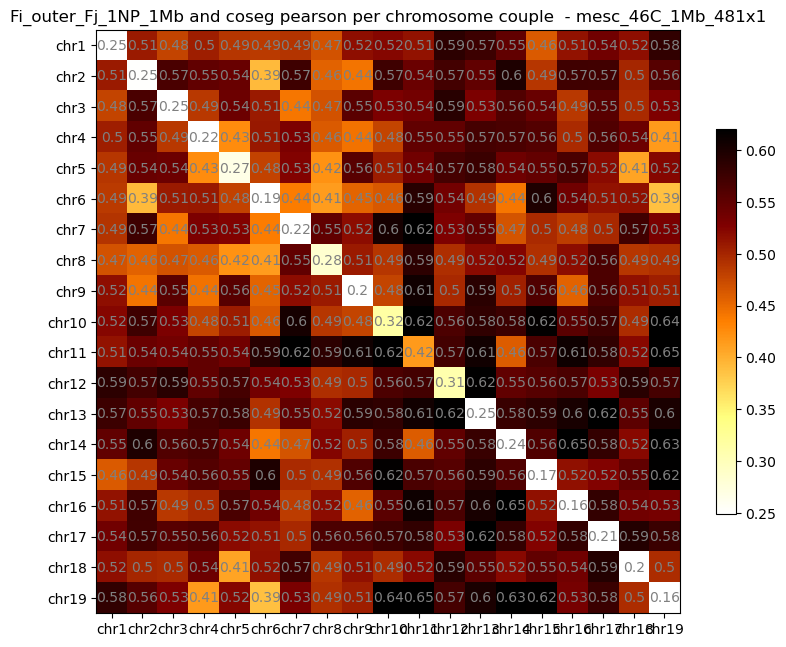

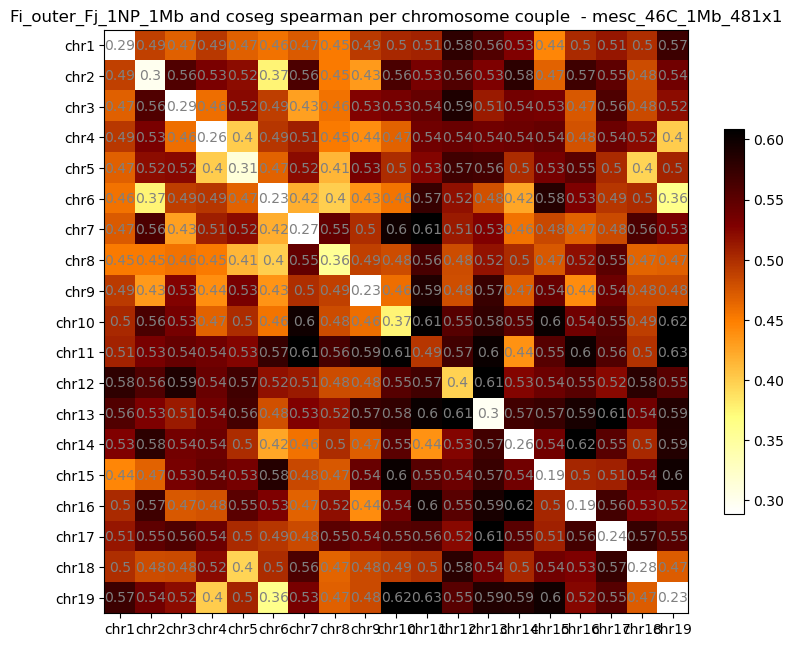

In [29]:
Rij_FixFj_pearson = np.zeros((19,19))
Rij_FixFj_spearman = np.zeros((19,19))

for i in range(n_chromosomes):
    for j in range(n_chromosomes):
        start_row    = np.sum(chr_windows_sizes[:i])
        stop_row     = start_row + chr_windows_sizes[i]
        start_column = np.sum(chr_windows_sizes[:j])
        stop_column  = start_column + chr_windows_sizes[j]
        chrA = chromosomes[i]
        chrB = chromosomes[j]


        f_mat = R_ij_gw_1NP_1Mb[start_row:stop_row, start_column:stop_column].flatten()
        f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[start_row:stop_row, start_column:stop_column]).flatten()
        bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

        f_mat = np.compress(bad, f_mat)  
        f_mat_1 = np.compress(bad, f_mat_1)  

        Rij_FixFj_pearson[i, j] = pearsonr(f_mat, f_mat_1)[0]
        Rij_FixFj_spearman[i, j] = spearmanr(f_mat, f_mat_1)[0]
            

fig, ax, _, _ = plot_heatmap(Rij_FixFj_pearson, x_figsize= 8, y_figsize= 8)
fig1, ax1, _, _ = plot_heatmap(Rij_FixFj_spearman, x_figsize= 8, y_figsize= 8)

for i in range(19):
    for j in range(19):
        text = ax.text(j, i, np.around(Rij_FixFj_pearson[i, j], decimals=2),
                       ha="center", va="center", color="grey")
        text = ax1.text(j, i, np.around(Rij_FixFj_spearman[i, j], decimals=2),
                       ha="center", va="center", color="grey")


ax.set_title("Fi_outer_Fj_1NP_1Mb and coseg pearson per chromosome couple " + " - " + name_root_1NP_1Mb)
fig.tight_layout()
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);

ax1.set_title("Fi_outer_Fj_1NP_1Mb and coseg spearman per chromosome couple " + " - " + name_root_1NP_1Mb)
fig1.tight_layout()
ax1.set_xticks(np.arange(0,19, 1))
ax1.set_yticks(np.arange(0,19, 1))
ax1.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax1.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);


del fig, ax, fig1, ax1

# Only chr12 and 18 # 

In [30]:
chr12_start, chr12_end, chr18_start, chr18_end = select_chromosomes_coordinates(12, 18, chr_windows_sizes)

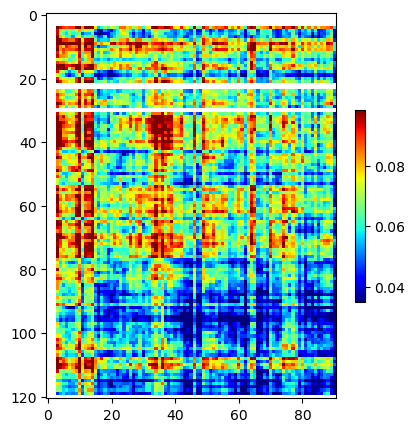

In [31]:
plot_heatmap(gw_coseg_matrix_1NP[chr12_start:chr12_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");

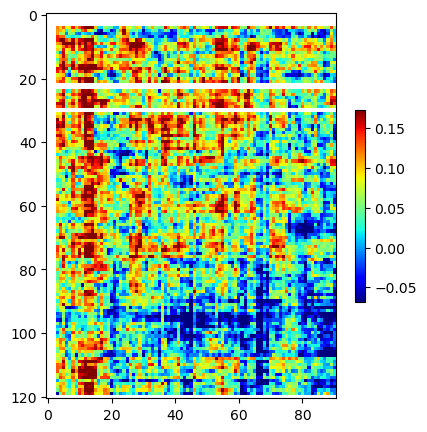

In [32]:
plot_heatmap(gw_npmi_1NP[chr12_start:chr12_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");

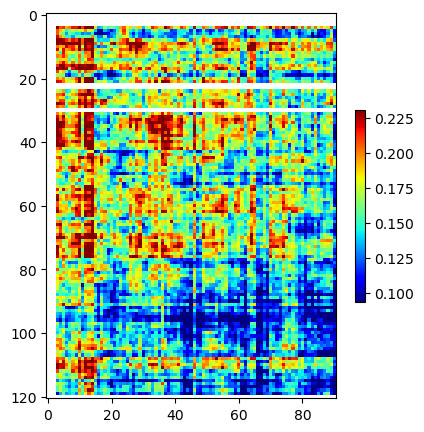

In [33]:
plot_heatmap(R_ij_gw_1NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");

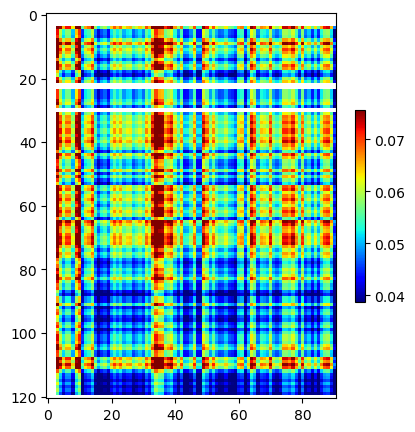

In [34]:
plot_heatmap(F_i_outer_Fj_1NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");

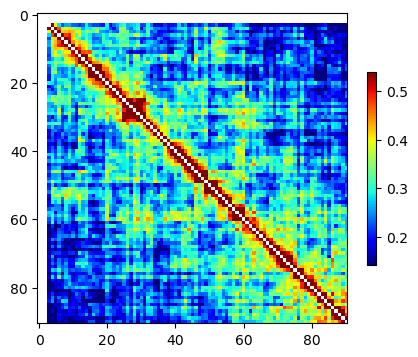

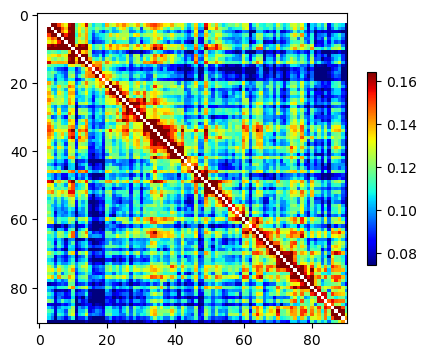

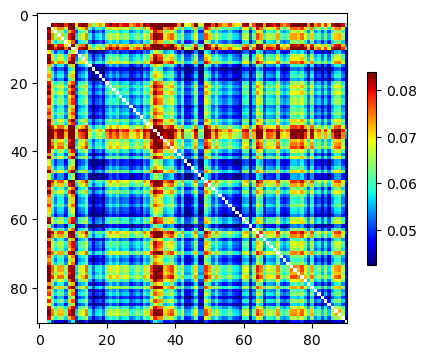

In [35]:
plot_heatmap(gw_npmi_1NP[chr18_start:chr18_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");
plot_heatmap(gw_coseg_matrix_1NP[chr18_start:chr18_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");
plot_heatmap(F_i_outer_Fj_1NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");

In [36]:
pi_chr12_1NP = squareform(np.loadtxt("/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/mesc_46C_1Mb_481x1/PI2/PI2_chr12_mesc_46C_1Mb_481x1.txt"))
pi_chr18_1NP = squareform(np.loadtxt("/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/mesc_46C_1Mb_481x1/PI2/PI2_chr18_mesc_46C_1Mb_481x1.txt"))
pi_chr12_18_1NP = np.load("/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/mesc_46C_1Mb_481x1/PI2_inter_beta_evaluation/PI2_inter_chr12_chr18_mesc_46C_1Mb_481x1.npy")

In [37]:
print("Chromosome 12, correlations with F_i x F_j")

f_mat = gw_coseg_matrix_1NP[chr12_start:chr12_end, chr12_start:chr12_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr12_start:chr12_end, chr12_start:chr12_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("coseg correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = gw_npmi_1NP[chr12_start:chr12_end, chr12_start:chr12_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr12_start:chr12_end, chr12_start:chr12_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("npmi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = R_ij_gw_1NP_1Mb[chr12_start:chr12_end, chr12_start:chr12_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr12_start:chr12_end, chr12_start:chr12_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("Rij correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 



f_mat = pi_chr12_1NP.flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr12_start:chr12_end, chr12_start:chr12_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("pi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

Chromosome 12, correlations with F_i x F_j
coseg correlation with F_ixF_j:	pearson 0.6406115101424354 	spearman  0.6900496301845168
npmi correlation with F_ixF_j:	pearson 0.09103955643311384 	spearman  0.13334543643869343
Rij correlation with F_ixF_j:	pearson 0.3087693228286056 	spearman  0.3966050252297897
pi correlation with F_ixF_j:	pearson 0.21829904353112528 	spearman  0.23268780399185793


In [38]:
print("Chromosome 18, correlations with F_i x F_j")

f_mat = gw_coseg_matrix_1NP[chr18_start:chr18_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("coseg correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = gw_npmi_1NP[chr18_start:chr18_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("npmi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = R_ij_gw_1NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("Rij correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 



f_mat = pi_chr18_1NP.flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("pi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

Chromosome 18, correlations with F_i x F_j
coseg correlation with F_ixF_j:	pearson 0.6180620811924074 	spearman  0.6574308371535086
npmi correlation with F_ixF_j:	pearson -0.06308468331968743 	spearman  -0.0570791961242494
Rij correlation with F_ixF_j:	pearson 0.20249896791281902 	spearman  0.27727172276810524
pi correlation with F_ixF_j:	pearson 0.11503471338575308 	spearman  0.14911002181941865


In [39]:
print("Chromosome 12-18 inter, correlations with F_i x F_j")

f_mat = gw_coseg_matrix_1NP[chr12_start:chr12_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("coseg correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = gw_npmi_1NP[chr12_start:chr12_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("npmi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = R_ij_gw_1NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("Rij correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 



f_mat = pi_chr12_18_1NP.flatten()
f_mat_1 = np.copy(F_i_outer_Fj_1NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("pi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

Chromosome 12-18 inter, correlations with F_i x F_j
coseg correlation with F_ixF_j:	pearson 0.7955967872428926 	spearman  0.7827722465759269
npmi correlation with F_ixF_j:	pearson 0.2354271762411137 	spearman  0.22831528577496676
Rij correlation with F_ixF_j:	pearson 0.5894753045364431 	spearman  0.5820285263372554
pi correlation with F_ixF_j:	pearson 0.35114593969649693 	spearman  0.3280927409279849


coseg correlation npmi:	pearson 0.7430779602446291 	spearman  0.6623923837350232


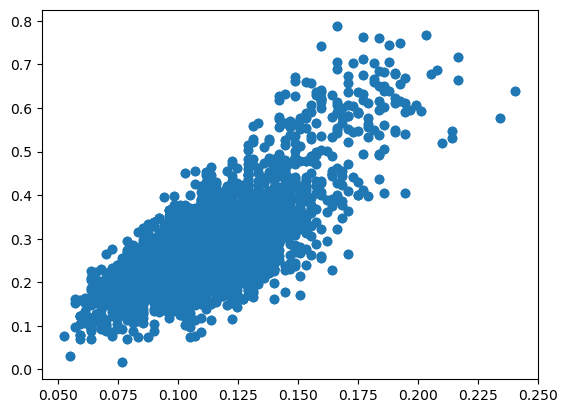

In [40]:
f_mat = gw_coseg_matrix_1NP[chr18_start:chr18_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(gw_npmi_1NP[chr18_start:chr18_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("coseg correlation npmi:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

plt.scatter(f_mat, f_mat_1)

del f_mat, f_mat_1, bad 

F_i x F_j correlation npmi:	pearson -0.06308468331968743 	spearman  -0.0570791961242494


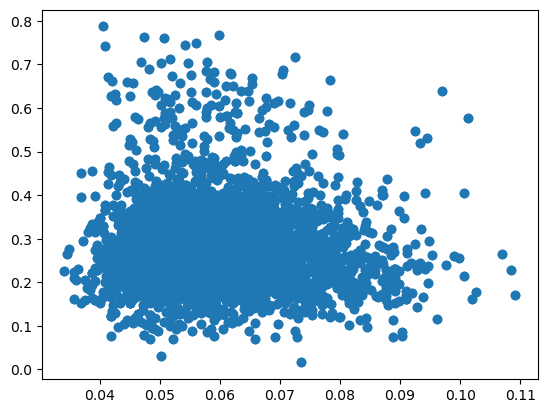

In [41]:
f_mat = F_i_outer_Fj_1NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(gw_npmi_1NP[chr18_start:chr18_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("F_i x F_j correlation npmi:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

plt.scatter(f_mat, f_mat_1)

del f_mat, f_mat_1, bad 

# 3NP #

# Data preparation and info #

In [42]:
#3NP
name_root_3NP_1Mb = "iza-mesc_1Mb_420x3"
path_1 =      r"/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/" + name_root_3NP_1Mb + "/"
file_name_1 = "segregation_" + name_root_3NP_1Mb +  ".pkl"
with open(path_1 + file_name_1, 'rb') as f_1:
    segregation_table_3NP = pickle.load(f_1)

gw_coseg_matrix_3NP, gw_npmi_3NP = compute_coseg_npmi_genomewide(segregation_table_3NP, 1, 19)

gw_coseg_matrix_3NP[gw_coseg_matrix_3NP == 0] = np.nan
gw_npmi_3NP[gw_npmi_3NP == 0] = np.nan

# For each chromosome, compute F_arr and store it in F_arr_genomewide
chr_list = list(dict({"chr1": 1, "chr2": 2, "chr3": 3, "chr4": 4,
                             "chr5": 5, "chr6": 6, "chr7": 7, "chr8": 8,
                             "chr9": 9, "chr10": 10, "chr11": 11, "chr12": 12,
                             "chr13": 13, "chr14": 14, "chr15": 15, "chr16": 16,
                             "chr17": 17, "chr18": 18, "chr19": 19}).keys())

F_arr_genomewide_3NP_1Mb = np.array([])

for chr in chr_list:
    segregation_table = segregation_table_3NP[chr]["segregation_table"]
    F_arr = compute_tube_segregation_frequency(segregation_table)
    F_arr_genomewide_3NP_1Mb = np.concatenate((F_arr_genomewide_3NP_1Mb, F_arr))
    del F_arr

del segregation_table


start_chr, stop_chr = 1, 19
stop_chr += 1
chromosomes = []
n_chromosomes = stop_chr - start_chr

l = []
size = 0

for i in range(start_chr, stop_chr):
    chrA = 'chr' + str(i)
    chromosomes += [chrA]
    s = segregation_table_3NP[chrA]['segregation_table'].shape[0]
    size += s
    l.append(s) 

chr_windows_sizes = np.array(l)

for i in range(gw_coseg_matrix_3NP.shape[0]):
    for j in range(gw_coseg_matrix_3NP.shape[1]):
        gw_coseg_matrix_3NP[j,i] = gw_coseg_matrix_3NP[i,j]
        gw_npmi_3NP[j,i] = gw_npmi_3NP[i, j]


  0%|          | 0/19 [00:00<?, ?it/s]/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/src/utilities.py:40: RuntimeWarning: divide by zero encountered in log
  npmi_mat = - np.log(F_ij / (F_i * F_j)) / np.log(F_ij)
/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/src/utilities.py:56: RuntimeWarning: divide by zero encountered in log
  npmi_mat = - np.log(F_ij / (F_i * F_j)) / np.log(F_ij)


In [43]:
F_i = np.tile(F_arr_genomewide_3NP_1Mb, (len(F_arr_genomewide_3NP_1Mb), 1))
F_j = np.transpose(F_i)
R_ij_gw_3NP_1Mb = gw_coseg_matrix_3NP / (F_i + F_j - gw_coseg_matrix_3NP)
del F_i, F_j

In [44]:
print("Dimensioni del dataset: " , gw_coseg_matrix_3NP.shape)
print("Numero di nan nella coseg"  , np.argwhere(gw_coseg_matrix_3NP != gw_coseg_matrix_3NP).shape)
print("Numero di nan nella nld  "    , np.argwhere(gw_npmi_3NP != gw_npmi_3NP).shape)

print("Numero di zeri nella coseg "  , np.argwhere(gw_coseg_matrix_3NP == 0).shape)
print("Numero di zeri nella nld "  ,   np.argwhere(gw_npmi_3NP == 0).shape)

Dimensioni del dataset:  (2473, 2473)
Numero di nan nella coseg (1529707, 2)
Numero di nan nella nld   (1536227, 2)
Numero di zeri nella coseg  (0, 2)
Numero di zeri nella nld  (0, 2)


In [47]:
temp_1 = F_arr_genomewide_1NP_1Mb[chr12_start:chr12_end]
temp_2 = gw_coseg_matrix_1NP[chr12_start:chr12_end, chr12_start:chr12_end]


In [50]:
temp_1[50], temp_1[35], temp_2[50,35]

(0.20787746170678337, 0.24507658643326038, 0.09190371991247265)

# $F_i \cdot F_j$ coseg corr #

In [ ]:
F_i_outer_Fj_3NP_1Mb = np.outer(F_arr_genomewide_3NP_1Mb, F_arr_genomewide_3NP_1Mb)
F_i_outer_Fj_3NP_1Mb[F_i_outer_Fj_3NP_1Mb == 0] = np.nan
np.fill_diagonal(F_i_outer_Fj_3NP_1Mb, np.nan)

(0.8855883555964904, 0.0)
SpearmanrResult(correlation=0.8910394212719901, pvalue=0.0)


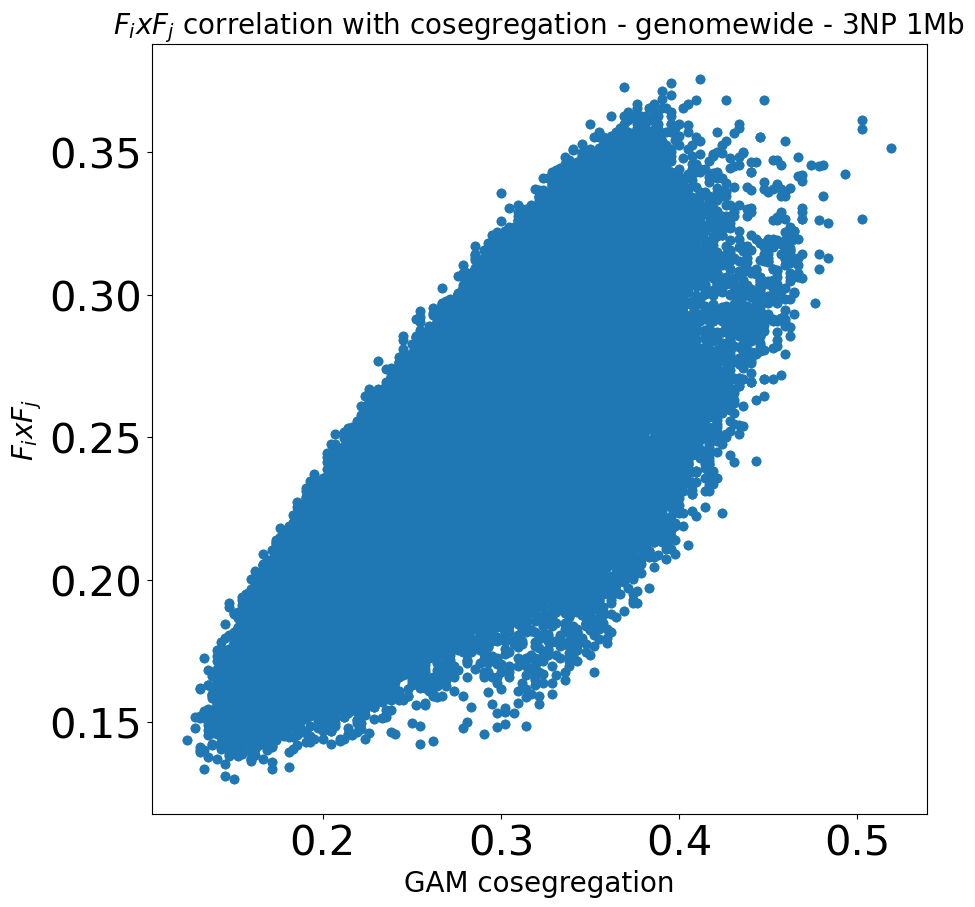

In [ ]:
fig, ax = plt.subplots(1, figsize = (10,10))

mat = gw_coseg_matrix_3NP
mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb)

ax.scatter(mat, mat_1);
ax.set_xlabel("GAM cosegregation", fontsize = 20);
ax.set_ylabel("$F_i x F_j$", fontsize = 20);

ax.set_title("$F_i x F_j$ correlation with cosegregation - genomewide - 3NP 1Mb", fontsize = 20)
ax.tick_params(axis='x', which='major', labelsize=30)
ax.tick_params(axis='y', which='major', labelsize=30)


f_mat = mat.flatten()
f_mat_1 = mat_1.flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print(pearsonr(f_mat, f_mat_1))
print(spearmanr(f_mat, f_mat_1))

del mat, mat_1, fig, ax, f_mat, f_mat_1

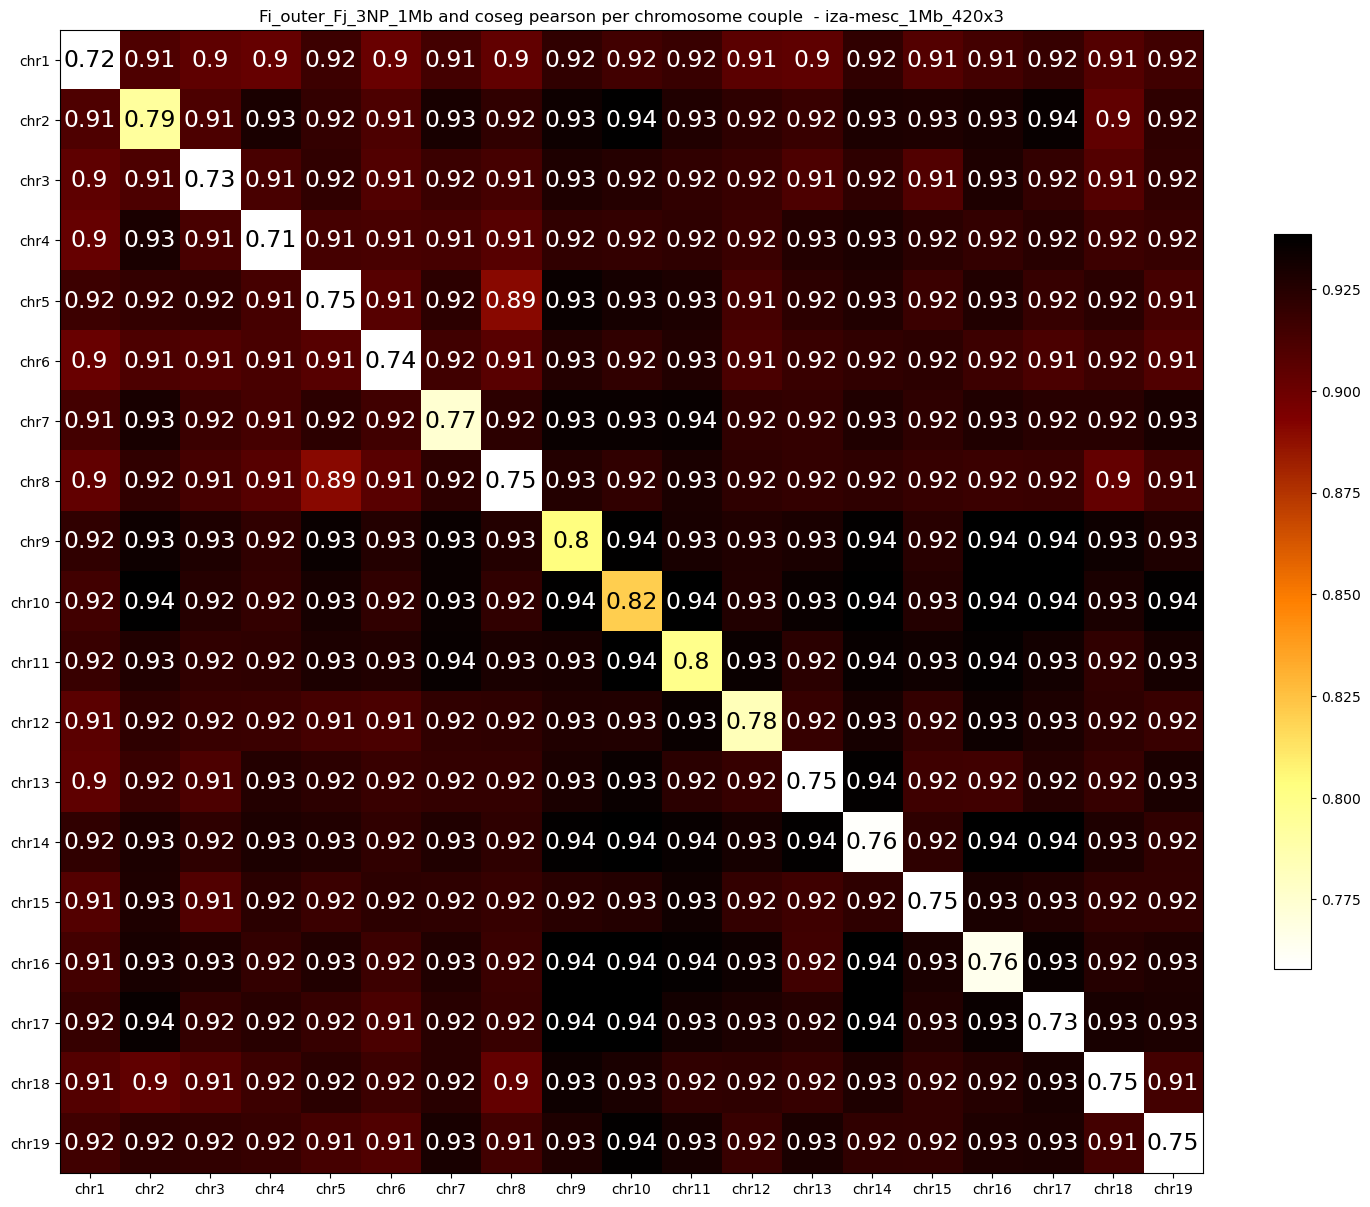

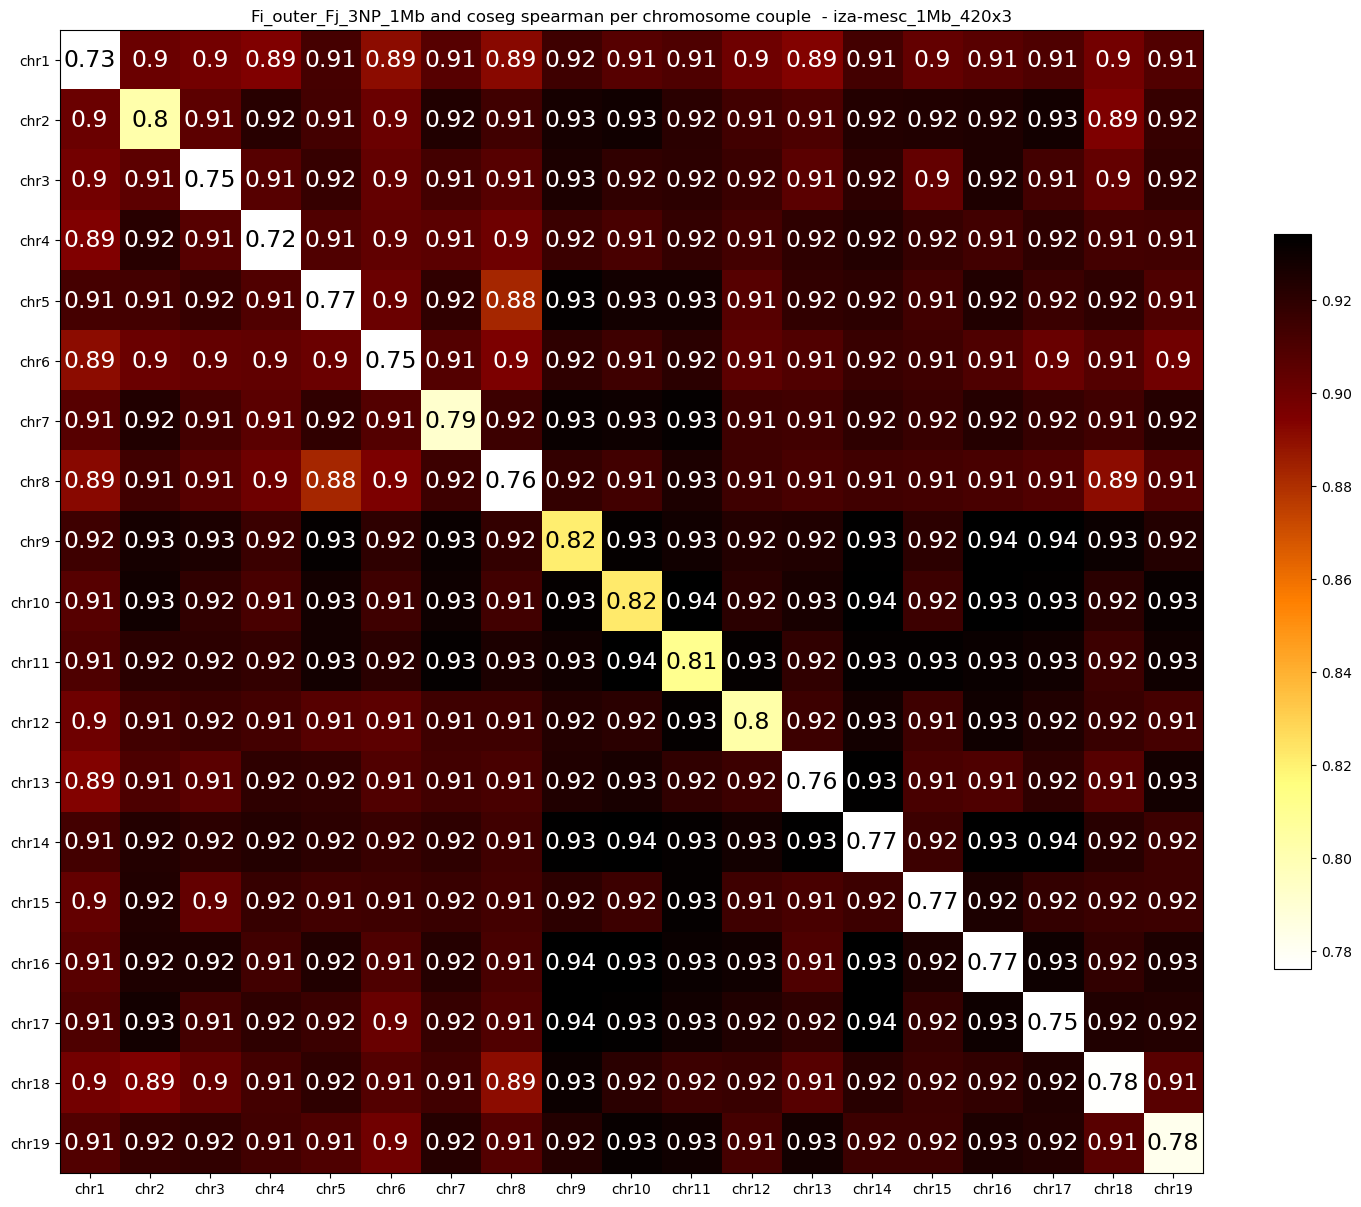

In [ ]:
coseg_FixFj_pearson_3NP = np.zeros((19,19))
coseg_FixFj_spearman_3NP = np.zeros((19,19))

for i in range(n_chromosomes):
    for j in range(n_chromosomes):
        start_row    = np.sum(chr_windows_sizes[:i])
        stop_row     = start_row + chr_windows_sizes[i]
        start_column = np.sum(chr_windows_sizes[:j])
        stop_column  = start_column + chr_windows_sizes[j]
        chrA = chromosomes[i]
        chrB = chromosomes[j]


        f_mat = gw_coseg_matrix_3NP[start_row:stop_row, start_column:stop_column].flatten()
        f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[start_row:stop_row, start_column:stop_column]).flatten()
        bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

        f_mat = np.compress(bad, f_mat)  
        f_mat_1 = np.compress(bad, f_mat_1)  

        coseg_FixFj_pearson_3NP[i, j] = pearsonr(f_mat, f_mat_1)[0]
        coseg_FixFj_spearman_3NP[i, j] = spearmanr(f_mat, f_mat_1)[0]
            

fig, ax, _, _ = plot_heatmap(coseg_FixFj_pearson_3NP, x_figsize= 15, y_figsize= 15)
fig1, ax1, _, _ = plot_heatmap(coseg_FixFj_spearman_3NP, x_figsize= 15, y_figsize= 15)

for i in range(19):
    for j in range(19):
        if(i!=j):
            text = ax.text(j, i, np.around(coseg_FixFj_pearson_3NP[i, j], decimals=2),
                        ha="center", va="center", color="white", fontsize = 17)
            text = ax1.text(j, i, np.around(coseg_FixFj_spearman_3NP[i, j], decimals=2),
                        ha="center", va="center", color="white", fontsize = 17)
        if(i==j):
            text = ax.text(j, i, np.around(coseg_FixFj_pearson_3NP[i, j], decimals=2),
                        ha="center", va="center", color="black", fontsize = 17)
            text = ax1.text(j, i, np.around(coseg_FixFj_spearman_3NP[i, j], decimals=2),
                        ha="center", va="center", color="black", fontsize = 17)


ax.set_title("Fi_outer_Fj_3NP_1Mb and coseg pearson per chromosome couple " + " - " + name_root_3NP_1Mb)
fig.tight_layout()
ax.set_xticks(np.arange(0,19, 1))
ax.set_yticks(np.arange(0,19, 1))
ax.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);

ax1.set_title("Fi_outer_Fj_3NP_1Mb and coseg spearman per chromosome couple " + " - " + name_root_3NP_1Mb)
fig1.tight_layout()
ax1.set_xticks(np.arange(0,19, 1))
ax1.set_yticks(np.arange(0,19, 1))
ax1.set_xticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);
ax1.set_yticklabels(['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19']);


del fig, ax, fig1, ax1

# Only chromosome 12 and 18 #

In [ ]:
pi_chr12_3NP = squareform(np.loadtxt("/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/iza-mesc_1Mb_420x3/PI2/PI2_chr12_iza-mesc_1Mb_420x3.txt"))
pi_chr18_3NP = squareform(np.loadtxt("/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/iza-mesc_1Mb_420x3/PI2/PI2_chr18_iza-mesc_1Mb_420x3.txt"))
pi_chr12_18_3NP = np.load("/home/federico/Università/Tesi_magistrale/SLICE/slice_repository/data/iza-mesc_1Mb_420x3/PI2_inter_beta_evaluation/PI2_inter_chr12_chr18_iza-mesc_1Mb_420x3.npy")

In [ ]:
chr12_start, chr12_end, chr18_start, chr18_end = select_chromosomes_coordinates(12, 18, chr_windows_sizes)

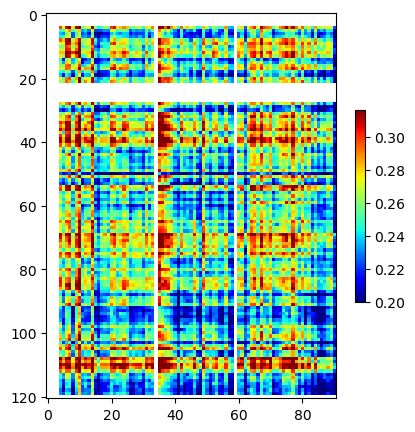

In [ ]:
plot_heatmap(gw_coseg_matrix_3NP[chr12_start:chr12_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");

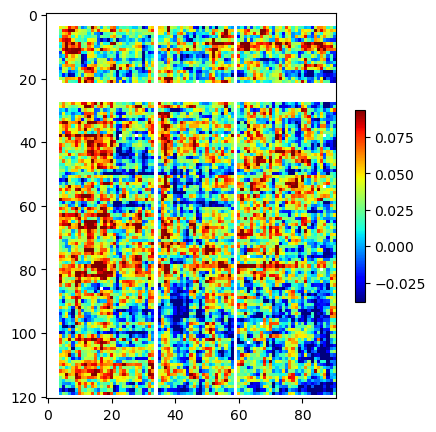

In [ ]:
plot_heatmap(gw_npmi_3NP[chr12_start:chr12_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");

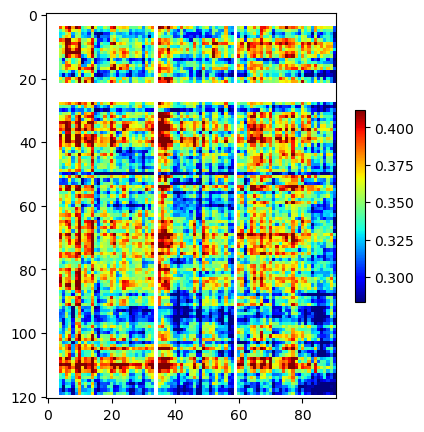

In [ ]:
plot_heatmap(R_ij_gw_3NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");

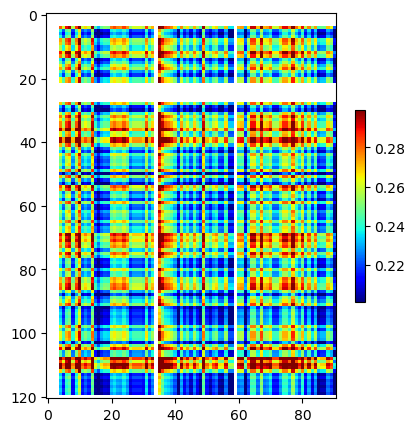

In [ ]:
plot_heatmap(F_i_outer_Fj_3NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");

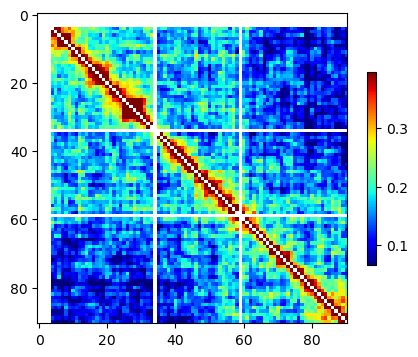

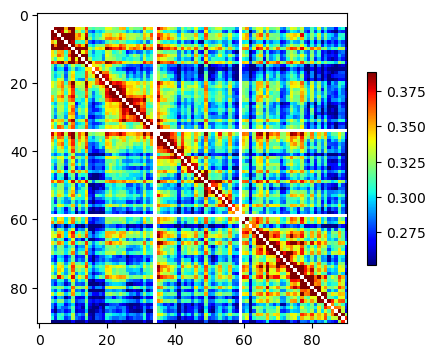

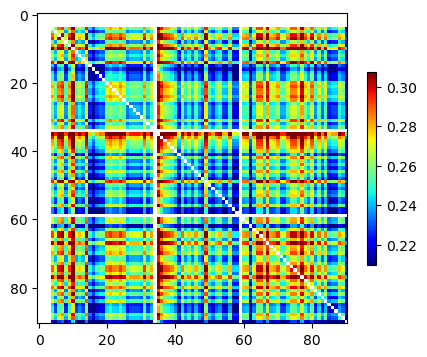

In [ ]:
plot_heatmap(gw_npmi_3NP[chr18_start:chr18_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");
plot_heatmap(gw_coseg_matrix_3NP[chr18_start:chr18_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");
plot_heatmap(F_i_outer_Fj_3NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end], x_figsize=5, y_figsize=5, colormap="jet");

In [ ]:
print("Chromosome 12, correlations with F_i x F_j")

f_mat = gw_coseg_matrix_3NP[chr12_start:chr12_end, chr12_start:chr12_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr12_start:chr12_end, chr12_start:chr12_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("coseg correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = gw_npmi_3NP[chr12_start:chr12_end, chr12_start:chr12_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr12_start:chr12_end, chr12_start:chr12_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("npmi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = R_ij_gw_3NP_1Mb[chr12_start:chr12_end, chr12_start:chr12_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr12_start:chr12_end, chr12_start:chr12_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("Rij correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 



f_mat = pi_chr12_3NP.flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr12_start:chr12_end, chr12_start:chr12_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("pi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

Chromosome 12, correlations with F_i x F_j
coseg correlation with F_ixF_j:	pearson 0.7826197670200856 	spearman  0.8031245765461582
npmi correlation with F_ixF_j:	pearson 0.07869044630977191 	spearman  0.11806214311227771
Rij correlation with F_ixF_j:	pearson 0.4630552709234088 	spearman  0.550606622126032
pi correlation with F_ixF_j:	pearson 0.5427588171674277 	spearman  0.525341355357755


In [ ]:
print("Chromosome 18, correlations with F_i x F_j")

f_mat = gw_coseg_matrix_3NP[chr18_start:chr18_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("coseg correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = gw_npmi_3NP[chr18_start:chr18_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("npmi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = R_ij_gw_3NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("Rij correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 



f_mat = pi_chr18_3NP.flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr18_start:chr18_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("pi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

Chromosome 18, correlations with F_i x F_j
coseg correlation with F_ixF_j:	pearson 0.7480522678309254 	spearman  0.7771471861329772
npmi correlation with F_ixF_j:	pearson -0.017847949441101622 	spearman  -0.007609342029012354
Rij correlation with F_ixF_j:	pearson 0.38618309637876086 	spearman  0.49327331086194565
pi correlation with F_ixF_j:	pearson 0.4451306333411556 	spearman  0.43957592379496957


In [ ]:
print("Chromosome 12-18 inter, correlations with F_i x F_j")

f_mat = gw_coseg_matrix_3NP[chr12_start:chr12_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("coseg correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = gw_npmi_3NP[chr12_start:chr12_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("npmi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

f_mat = R_ij_gw_3NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end].flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("Rij correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 



f_mat = pi_chr12_18_3NP.flatten()
f_mat_1 = np.copy(F_i_outer_Fj_3NP_1Mb[chr12_start:chr12_end, chr18_start:chr18_end]).flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print("pi correlation with F_ixF_j:\tpearson",  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

Chromosome 12-18 inter, correlations with F_i x F_j
coseg correlation with F_ixF_j:	pearson 0.9222632790698826 	spearman  0.9167092347543992
npmi correlation with F_ixF_j:	pearson 0.1183928630222449 	spearman  0.11101101663182147
Rij correlation with F_ixF_j:	pearson 0.77198674064504 	spearman  0.7589483016273316
pi correlation with F_ixF_j:	pearson 0.6366591506280156 	spearman  0.5956809495453902


# Exploration #

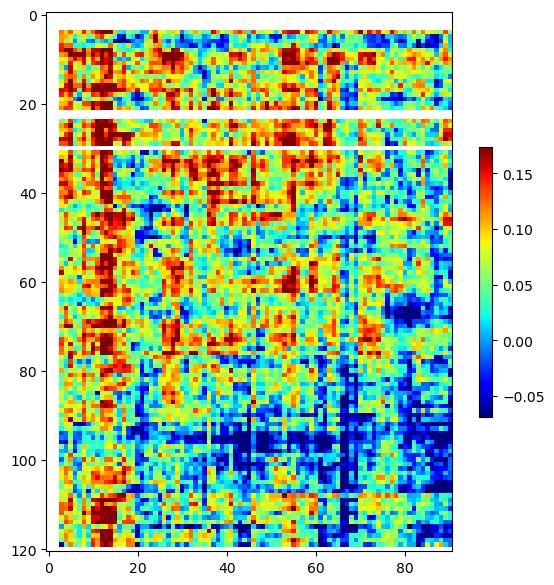

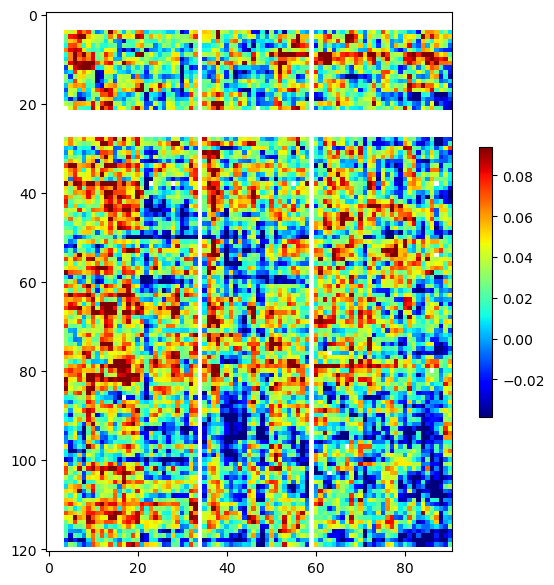

In [ ]:
plot_heatmap(gw_npmi_1NP[chr12_start:chr12_end, chr18_start:chr18_end], colormap = "jet");
plot_heatmap(gw_npmi_3NP[chr12_start:chr12_end, chr18_start:chr18_end], colormap = "jet");

In [ ]:
print("Correlation of NPMI between 1 and 3NP - chromosome 12 ")

f_mat = gw_npmi_1NP[chr12_start:chr12_end, chr12_start:chr12_end].flatten()
f_mat_1 = gw_npmi_3NP[chr12_start:chr12_end, chr12_start:chr12_end].flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print(  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

print("Correlation of NPMI between 1 and 3NP - chromosome 18 ")

f_mat = gw_npmi_1NP[chr18_start:chr18_end, chr12_start:chr18_end].flatten()
f_mat_1 = gw_npmi_3NP[chr18_start:chr18_end, chr12_start:chr18_end].flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print(  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

print("Correlation of NPMI between 1 and 3NP - chromosome 12 - 18 inter")

f_mat = gw_npmi_1NP[chr12_start:chr12_end, chr18_start:chr18_end].flatten()
f_mat_1 = gw_npmi_3NP[chr12_start:chr12_end, chr18_start:chr18_end].flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print( pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

Correlation of NPMI between 1 and 3NP - chromosome 12 
0.8416199451778226 	spearman  0.7436782930332396
Correlation of NPMI between 1 and 3NP - chromosome 18 
0.7636649956702177 	spearman  0.5262065134507461
Correlation of NPMI between 1 and 3NP - chromosome 12 - 18 inter
0.3475070457276638 	spearman  0.3296552012691437


In [ ]:
print("Correlation of pi between 1 and 3NP - chromosome 12 ")

f_mat = pi_chr12_1NP.flatten()
f_mat_1 = pi_chr12_3NP.flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print( pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

print("Correlation of pi between 1 and 3NP - chromosome 18 ")

f_mat = pi_chr18_1NP.flatten()
f_mat_1 = pi_chr18_3NP.flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print(  pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

print("Correlation of pi between 1 and 3NP - chromosome 12 - 18 inter")

f_mat = pi_chr12_18_1NP.flatten()
f_mat_1 = pi_chr12_18_3NP.flatten()
bad = ~np.logical_or(np.isnan(f_mat), np.isnan(f_mat_1))

f_mat = np.compress(bad, f_mat)  
f_mat_1 = np.compress(bad, f_mat_1)  

print( pearsonr(f_mat, f_mat_1)[0], "\tspearman " , spearmanr(f_mat, f_mat_1)[0])

del f_mat, f_mat_1, bad 

Correlation of pi between 1 and 3NP - chromosome 12 
0.37009442753794 	spearman  0.3353867880599231
Correlation of pi between 1 and 3NP - chromosome 18 
0.381747117475592 	spearman  0.36063620243029193
Correlation of pi between 1 and 3NP - chromosome 12 - 18 inter
0.2826741111429799 	spearman  0.24431309583418256
